In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import sys
import torch
import scipy
import corner
import copy
from copy import deepcopy

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
from populations.bbh_models import get_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [17]:
#flags/inputs:
param = ['mchirp','q', 'chieff', 'z', 's1x', 's1y', 's1z', 's2x',
       's2y', 's2z', 'pdet_midhighlatelow_network']
no_params = len(param)
channel_label = 'CE'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=20

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
#models_path ='/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/testing_notebooks/flow_samples.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']


In [3]:
#check that these distributions are the same between the whole (transformed distribution), batch, and the same for validation data
#no_trans, no_neurons, training_inputs, cond_inputs,no_binaries, batch_size, total_hps, RNVP=True, num_bins=4, device="cpu"):
flow = FlowModel(channel_label, popsynth_outputs, param, no_bins=4)
weighted_flow = FlowModel(channel_label, popsynth_outputs, param, no_bins=5)
model_names, KDE_models = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, normalize=False, detectable=False)
#_, KDE_models_detectable = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=True)


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


In [4]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [5]:
weighted_flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_210524_scatter/flow_models/flow_models/', channel_label)
#weighted_flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_011223/Flows_011223/flow_models_correctnonCEq/', channel_label)

## Unweighted flow distributions - nonCE

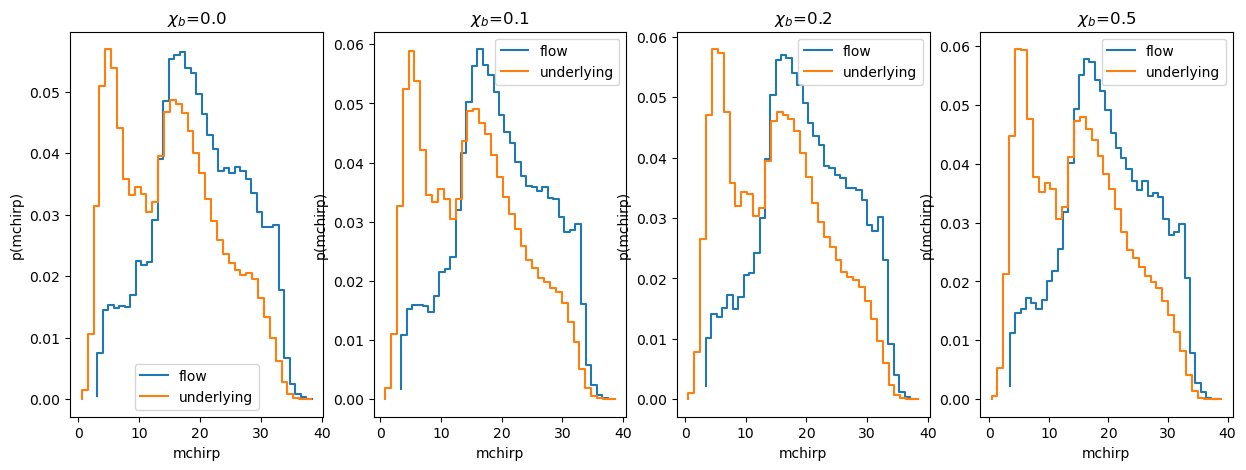

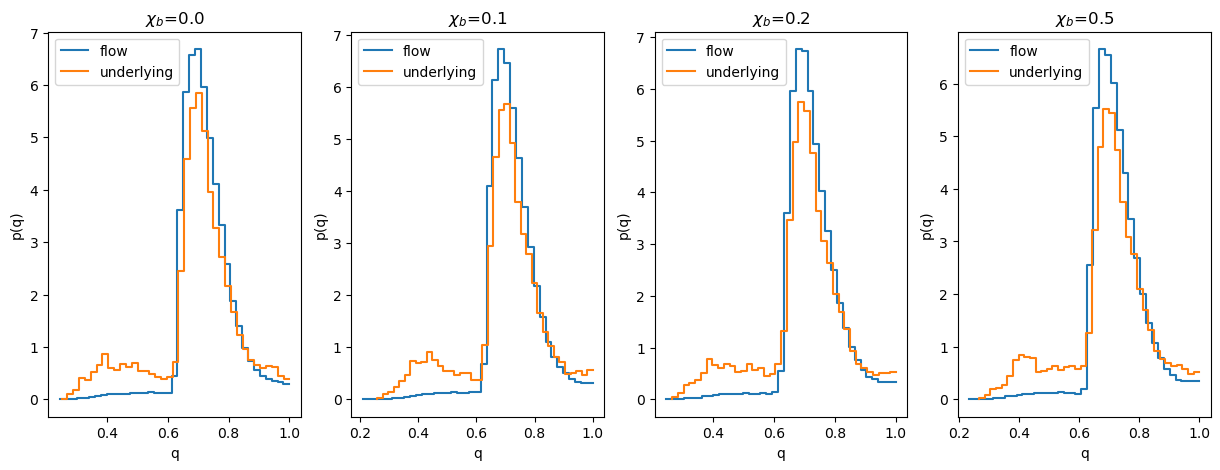

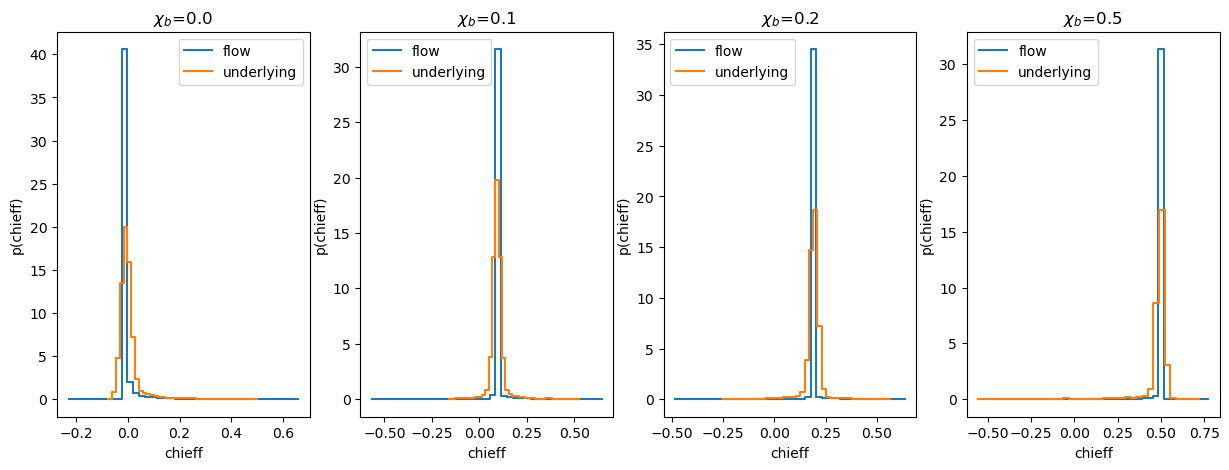

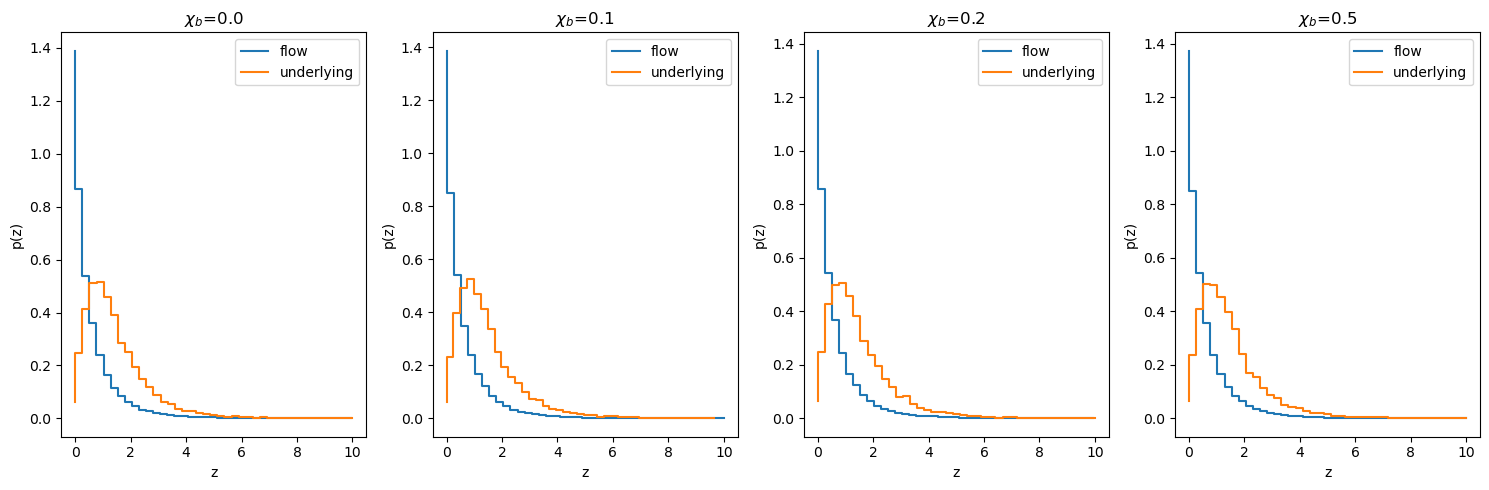

In [16]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 40

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = flow.flow.sample(np.array([xb]),no_samples)
    flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
    flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True)
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].legend()
        plt.tight_layout()

## Weighted Flow distributions - nonCE

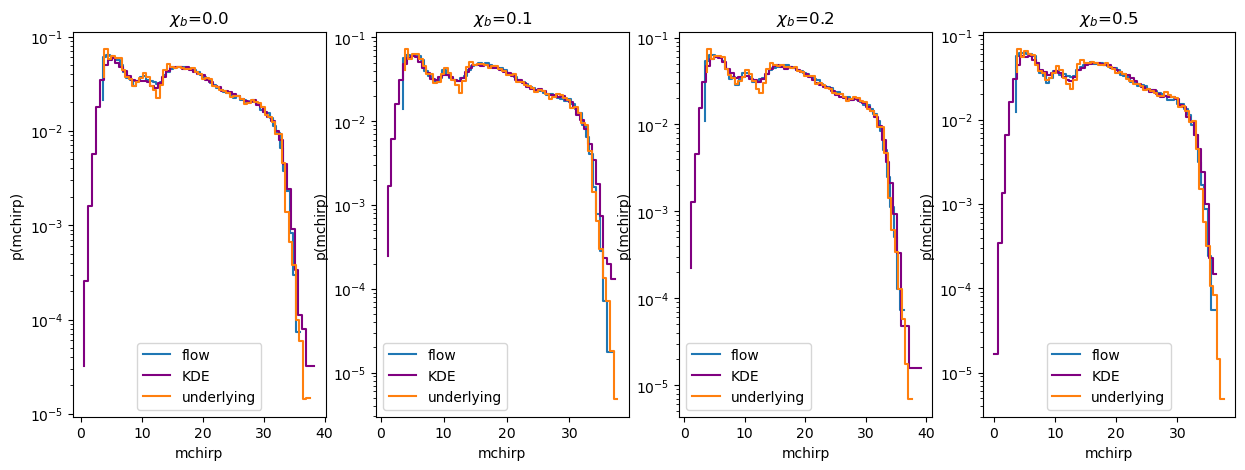

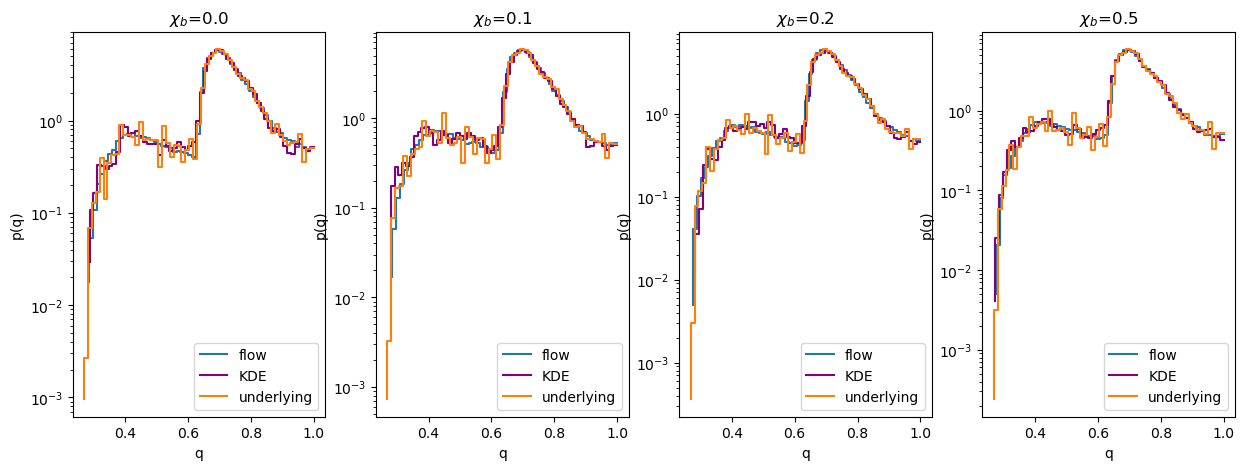

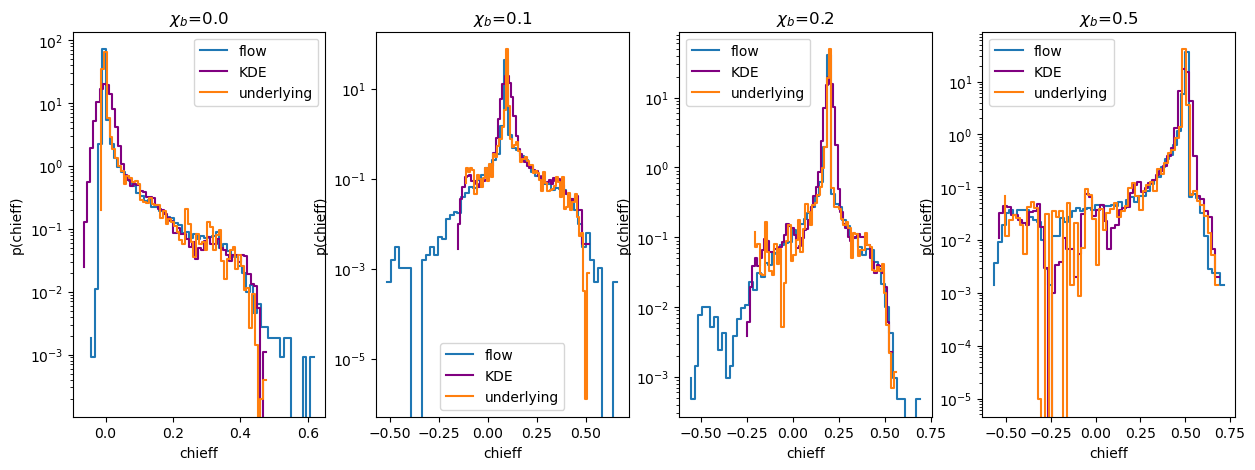

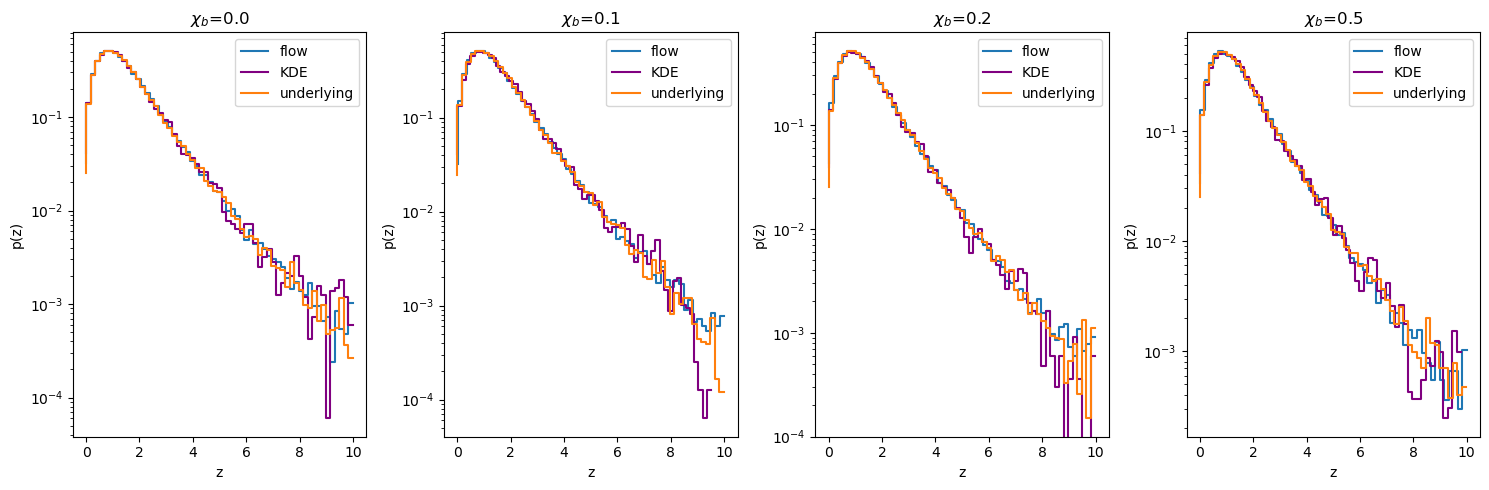

In [7]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = weighted_flow.flow.sample(np.array([xb]),no_samples)
    flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
    flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

    kde_samples = KDE_models[channel_label][submodels_dict[0][chi_b_id]].sample(no_samples)

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        kde_distr, bin_edges_KDE = np.histogram(kde_samples[:,i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True, weights=weights_dict[chi_b_id])
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_KDE[0],bin_edges_KDE[-1],no_bins),kde_distr,label='KDE', color='purple')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].set_yscale('log')
        ax[chi_b_id].legend()
        plt.tight_layout()

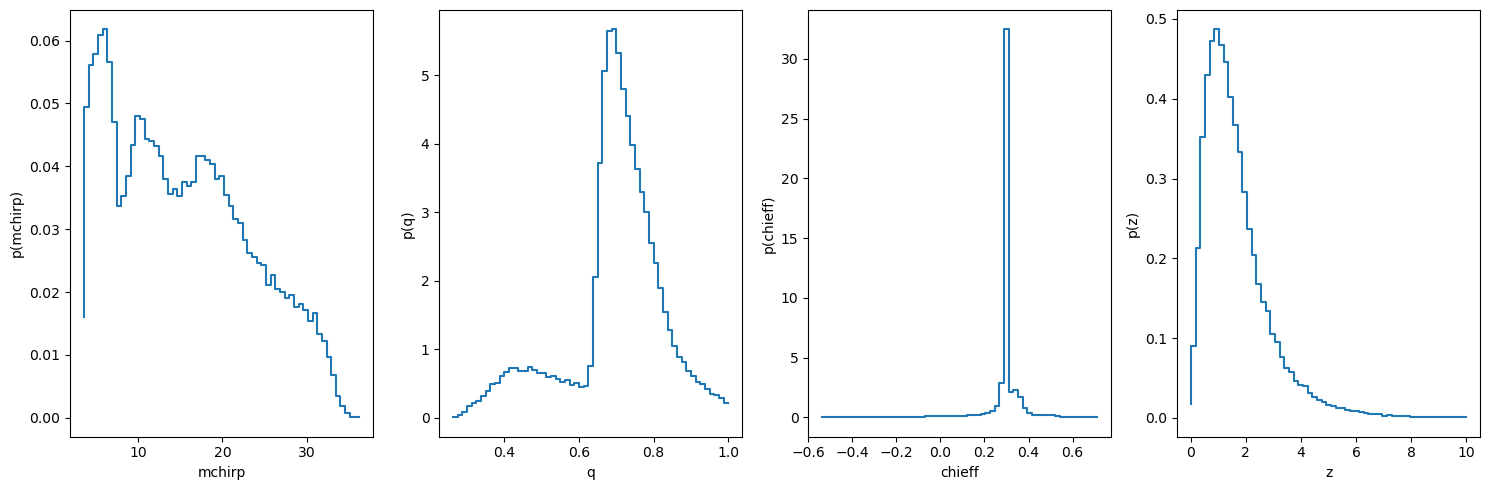

In [12]:
#checking example of flow interpolation
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 60

fig, ax = plt.subplots(1,4)

flow_samples_stack = weighted_flow.flow.sample(np.array([0.3]),no_samples)
flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_chieff = np.tanh(flow_samples_stack[:,2])
flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

for i, p in enumerate(param):
    flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
    ax[i].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
    ax[i].set_xlabel(f'{p}')
    ax[i].set_ylabel(f'p({p})')
    plt.tight_layout()

## Unweighted distributions - CE

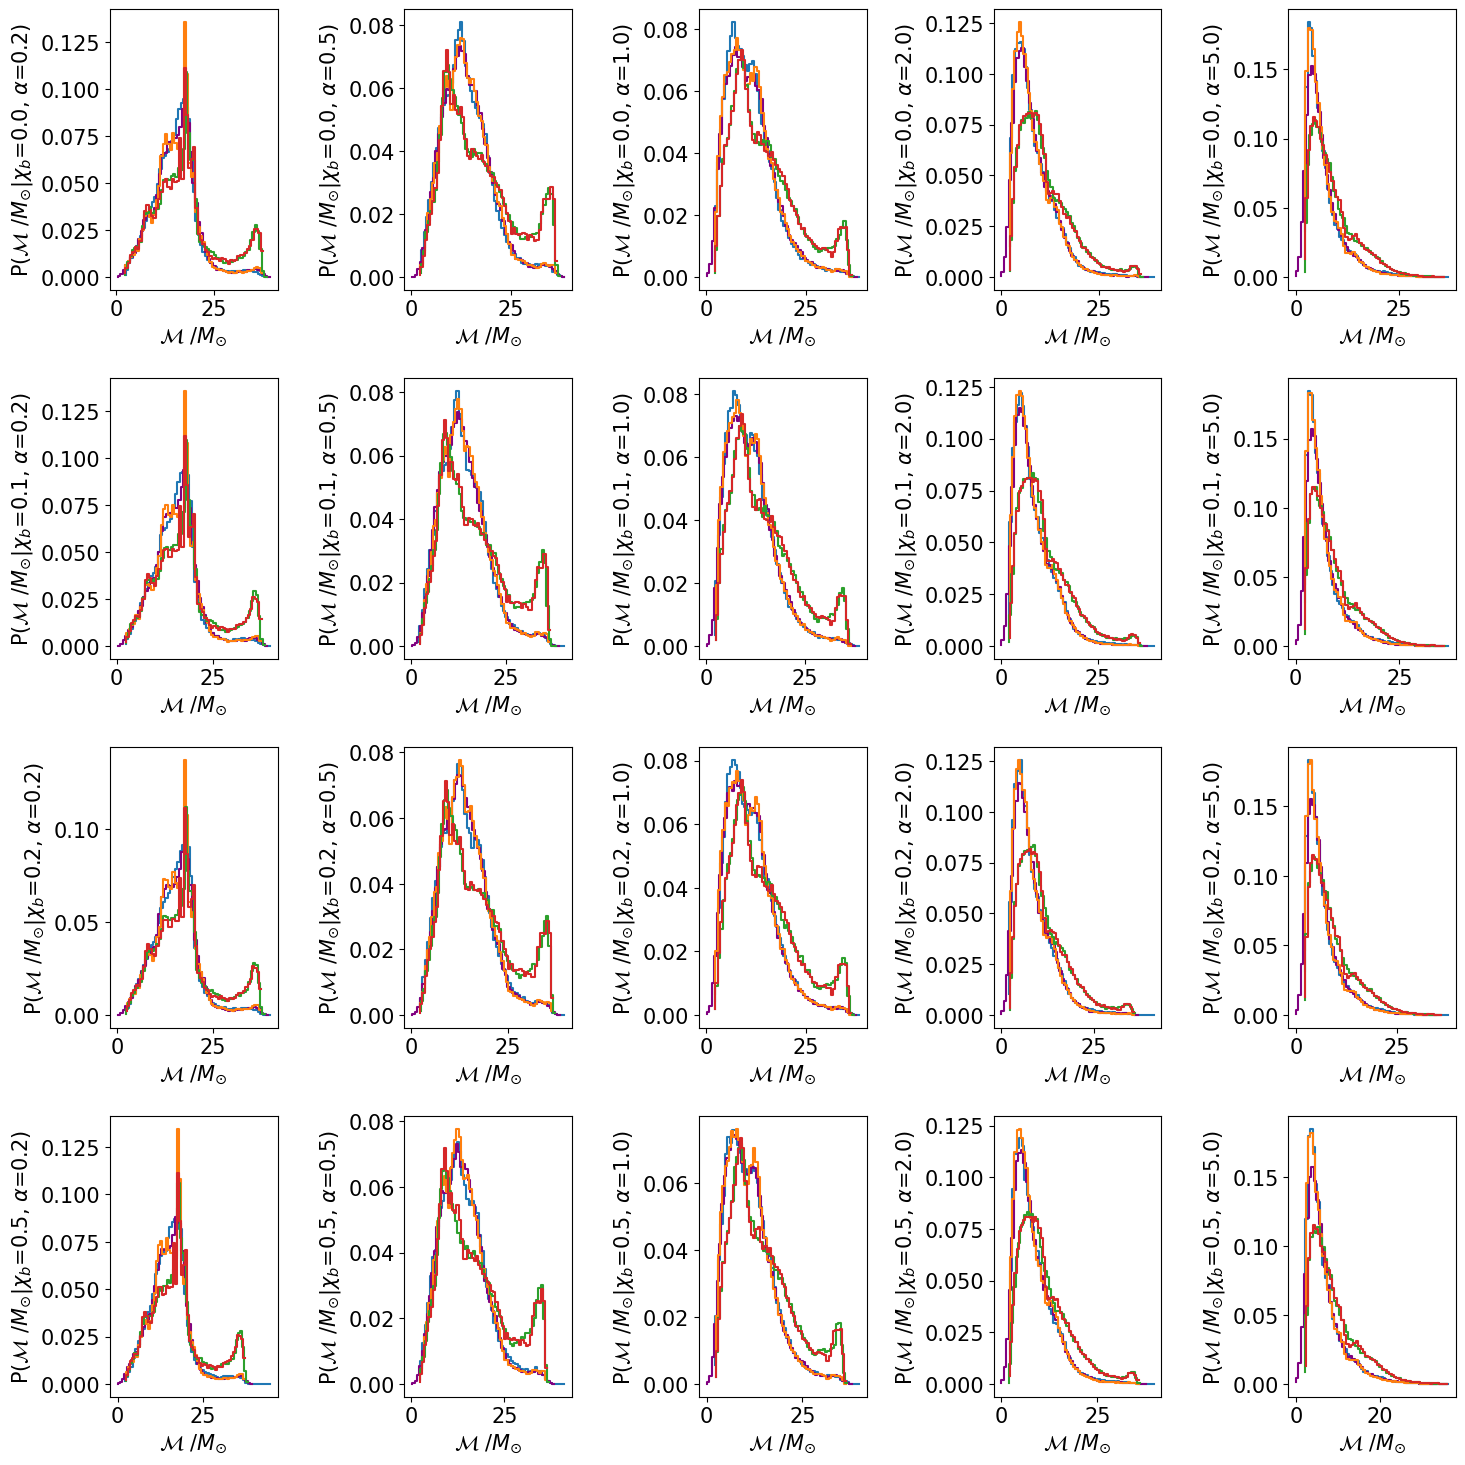

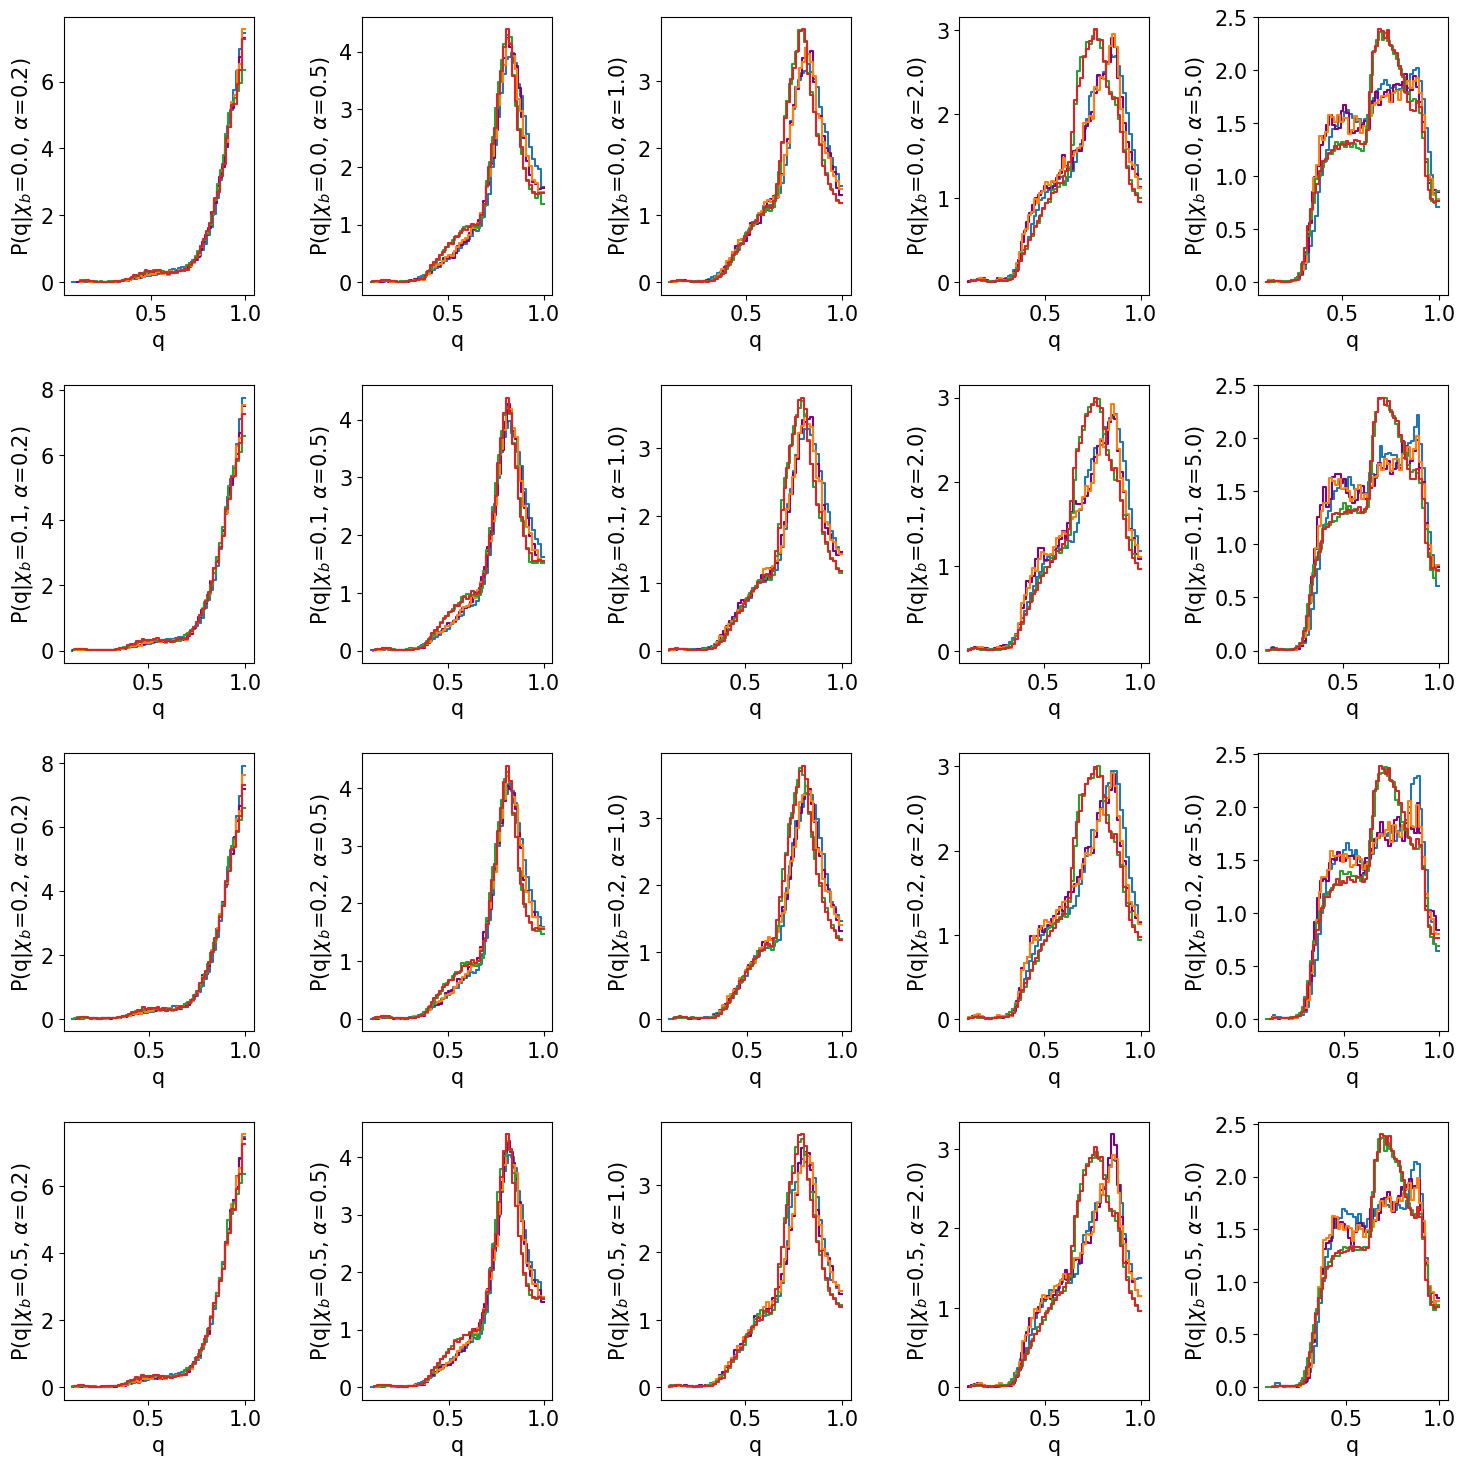

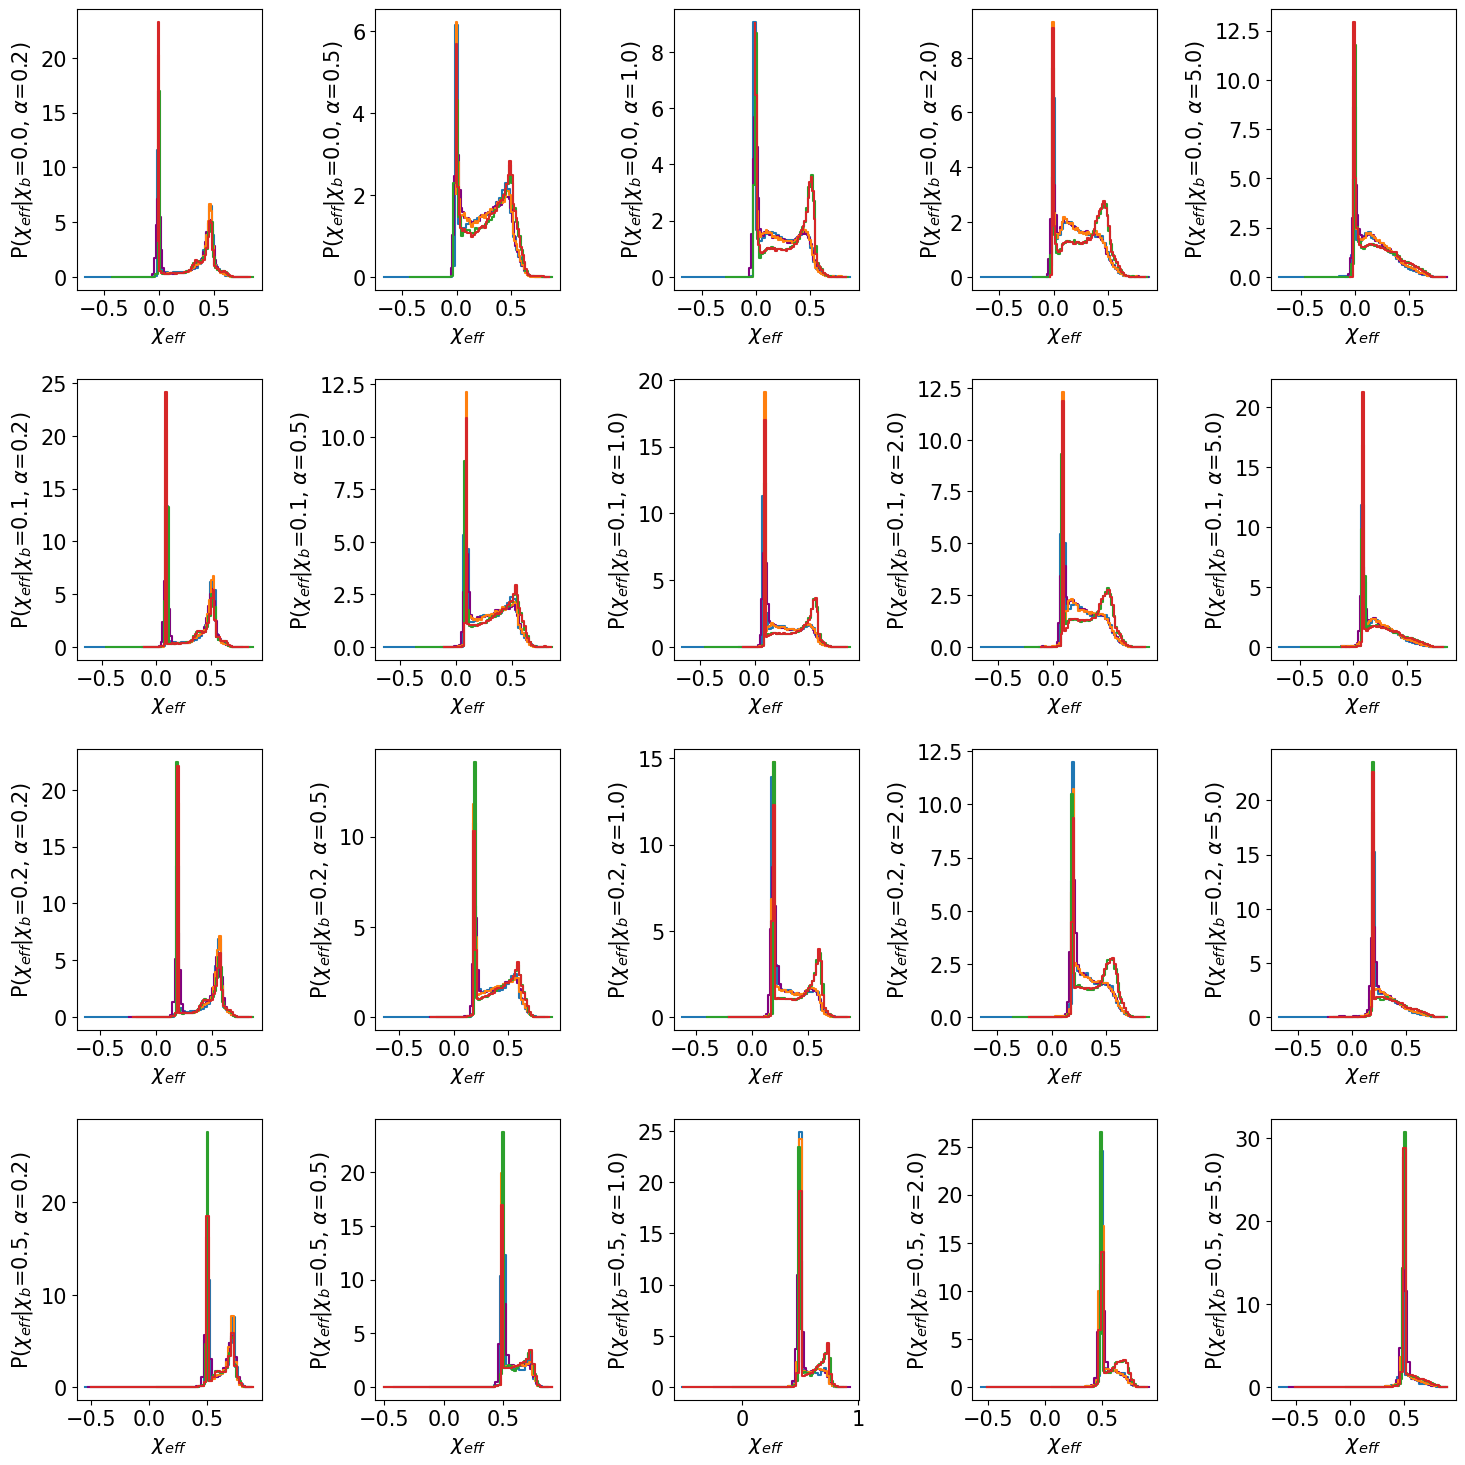

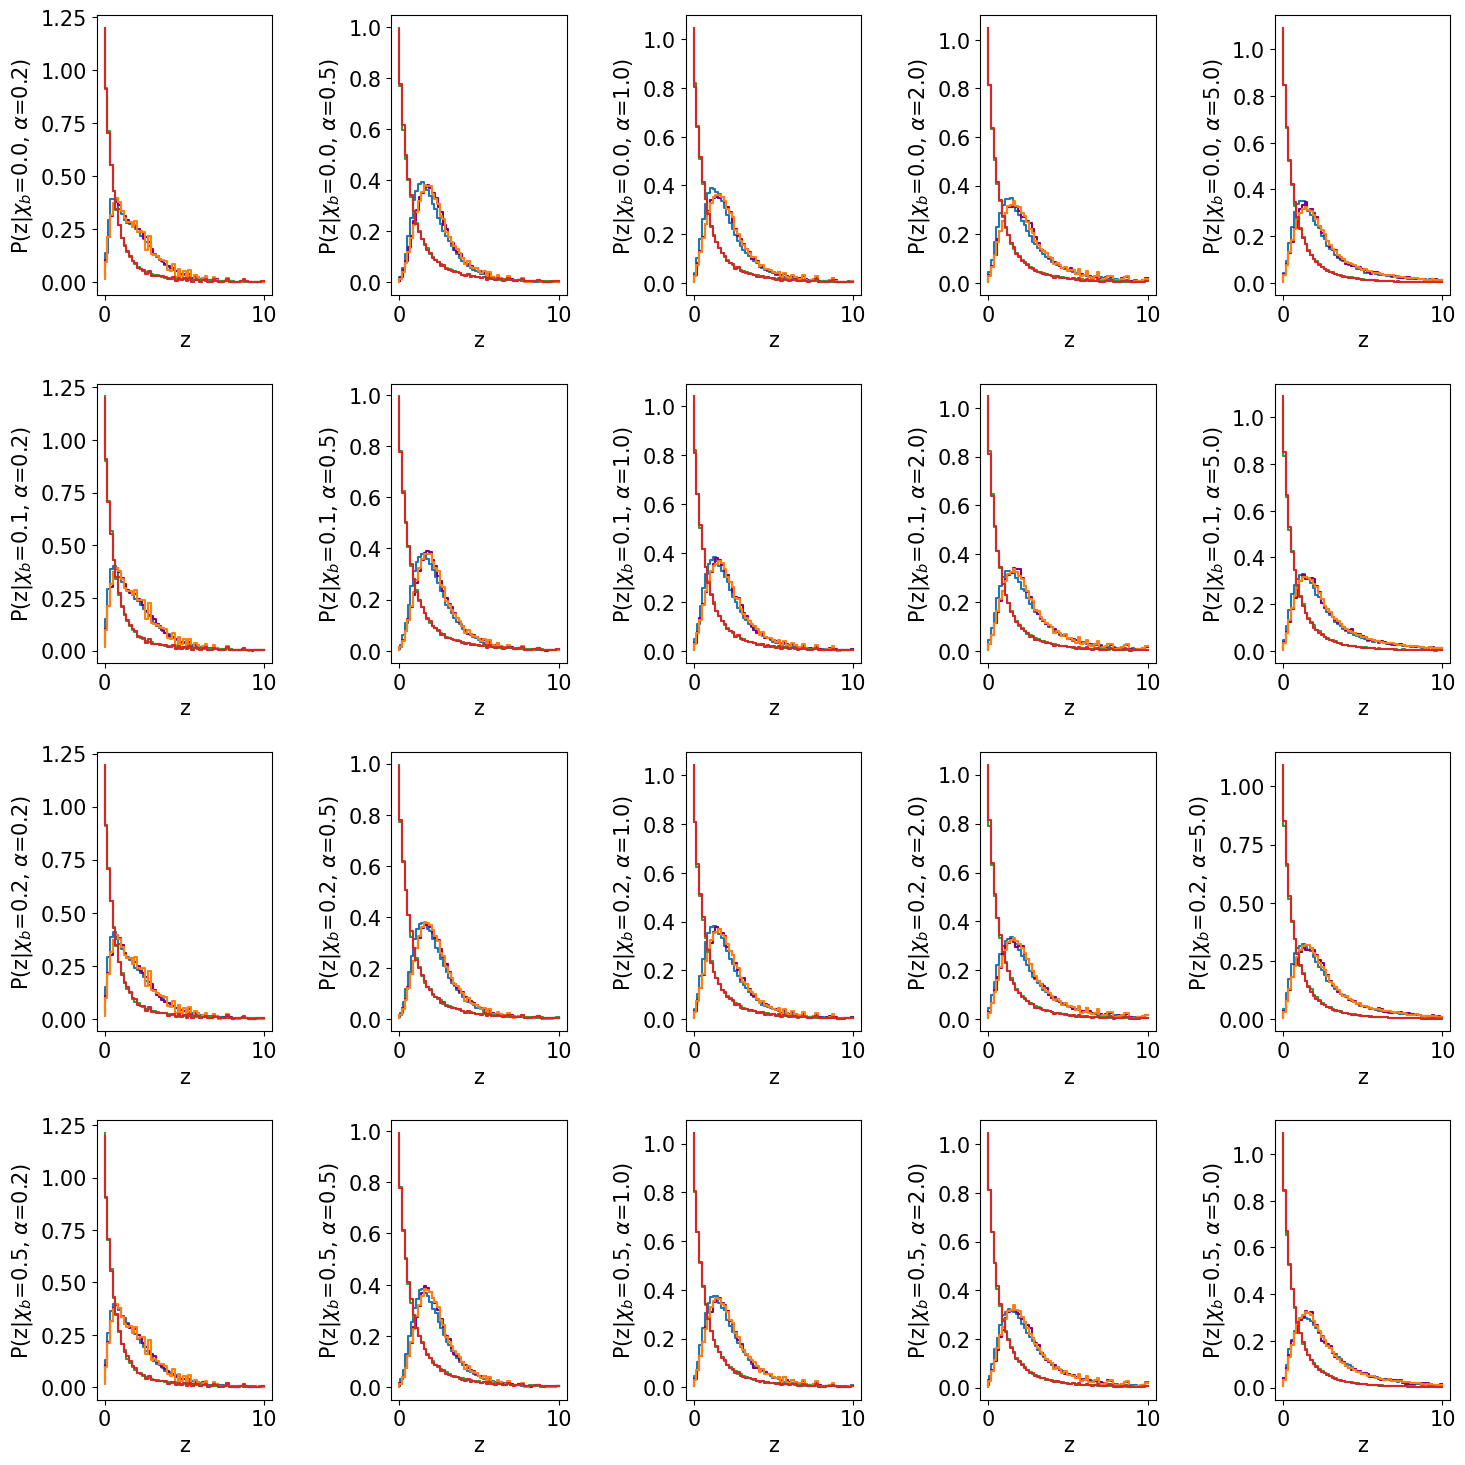

In [21]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = flow.flow.sample(np.array([xb,a]), no_samples)
        flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
        flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        wflow_samples_stack = weighted_flow.flow.sample(np.array([xb,a]), no_samples)
        wflow_mchirp = weighted_flow.expistic(wflow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
        wflow_q = weighted_flow.expistic(wflow_samples_stack[:,1], weighted_flow.mappings[2])
        wflow_chieff = np.tanh(wflow_samples_stack[:,2])
        wflow_z = weighted_flow.expistic(wflow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

        wmapped_flow_samples = [wflow_mchirp,wflow_q,wflow_chieff,wflow_z]
        wkde_samples = KDE_models['CE'][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]].sample(no_samples)


        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True)

            wflow_distr, wbin_edges = np.histogram(wmapped_flow_samples[i], bins=no_bins, density=True)
            wkde_distr, wbin_edges_KDE = np.histogram(wkde_samples[:,i], bins=no_bins, density=True)
            wknown_distr, wbin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id,alpha_id)][:])
            ax[chi_b_id,alpha_id].step(np.linspace(wbin_edges[0],wbin_edges[-1],no_bins),wflow_distr, label='weighted flow')
            ax[chi_b_id,alpha_id].step(np.linspace(wbin_edges_KDE[0],wbin_edges_KDE[-1],no_bins),wkde_distr,label='KDE', color='purple')
            ax[chi_b_id,alpha_id].step(np.linspace(wbin_edges_known[0],wbin_edges_known[-1],no_bins),wknown_distr,label='underlying')

            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            #ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

## Cosmo weighted Distributions - CE

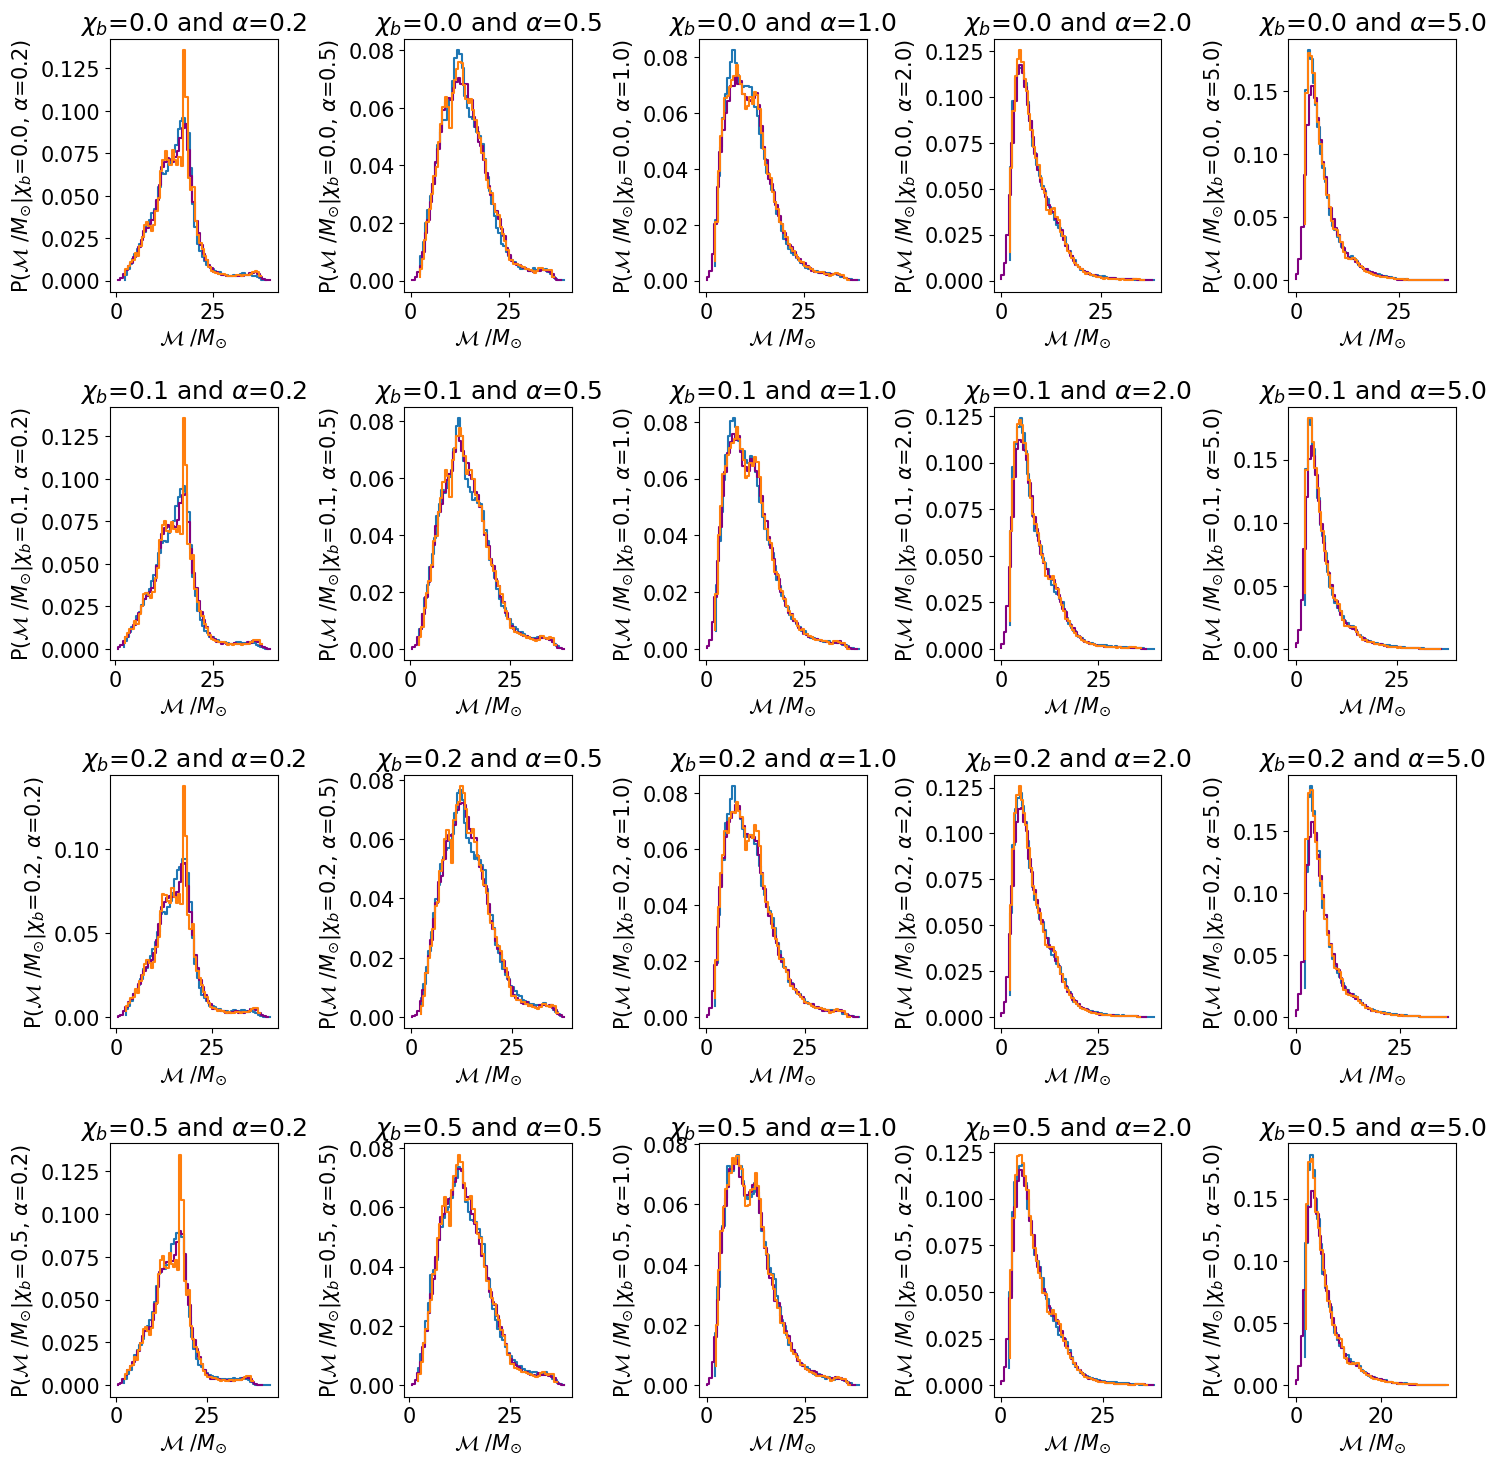

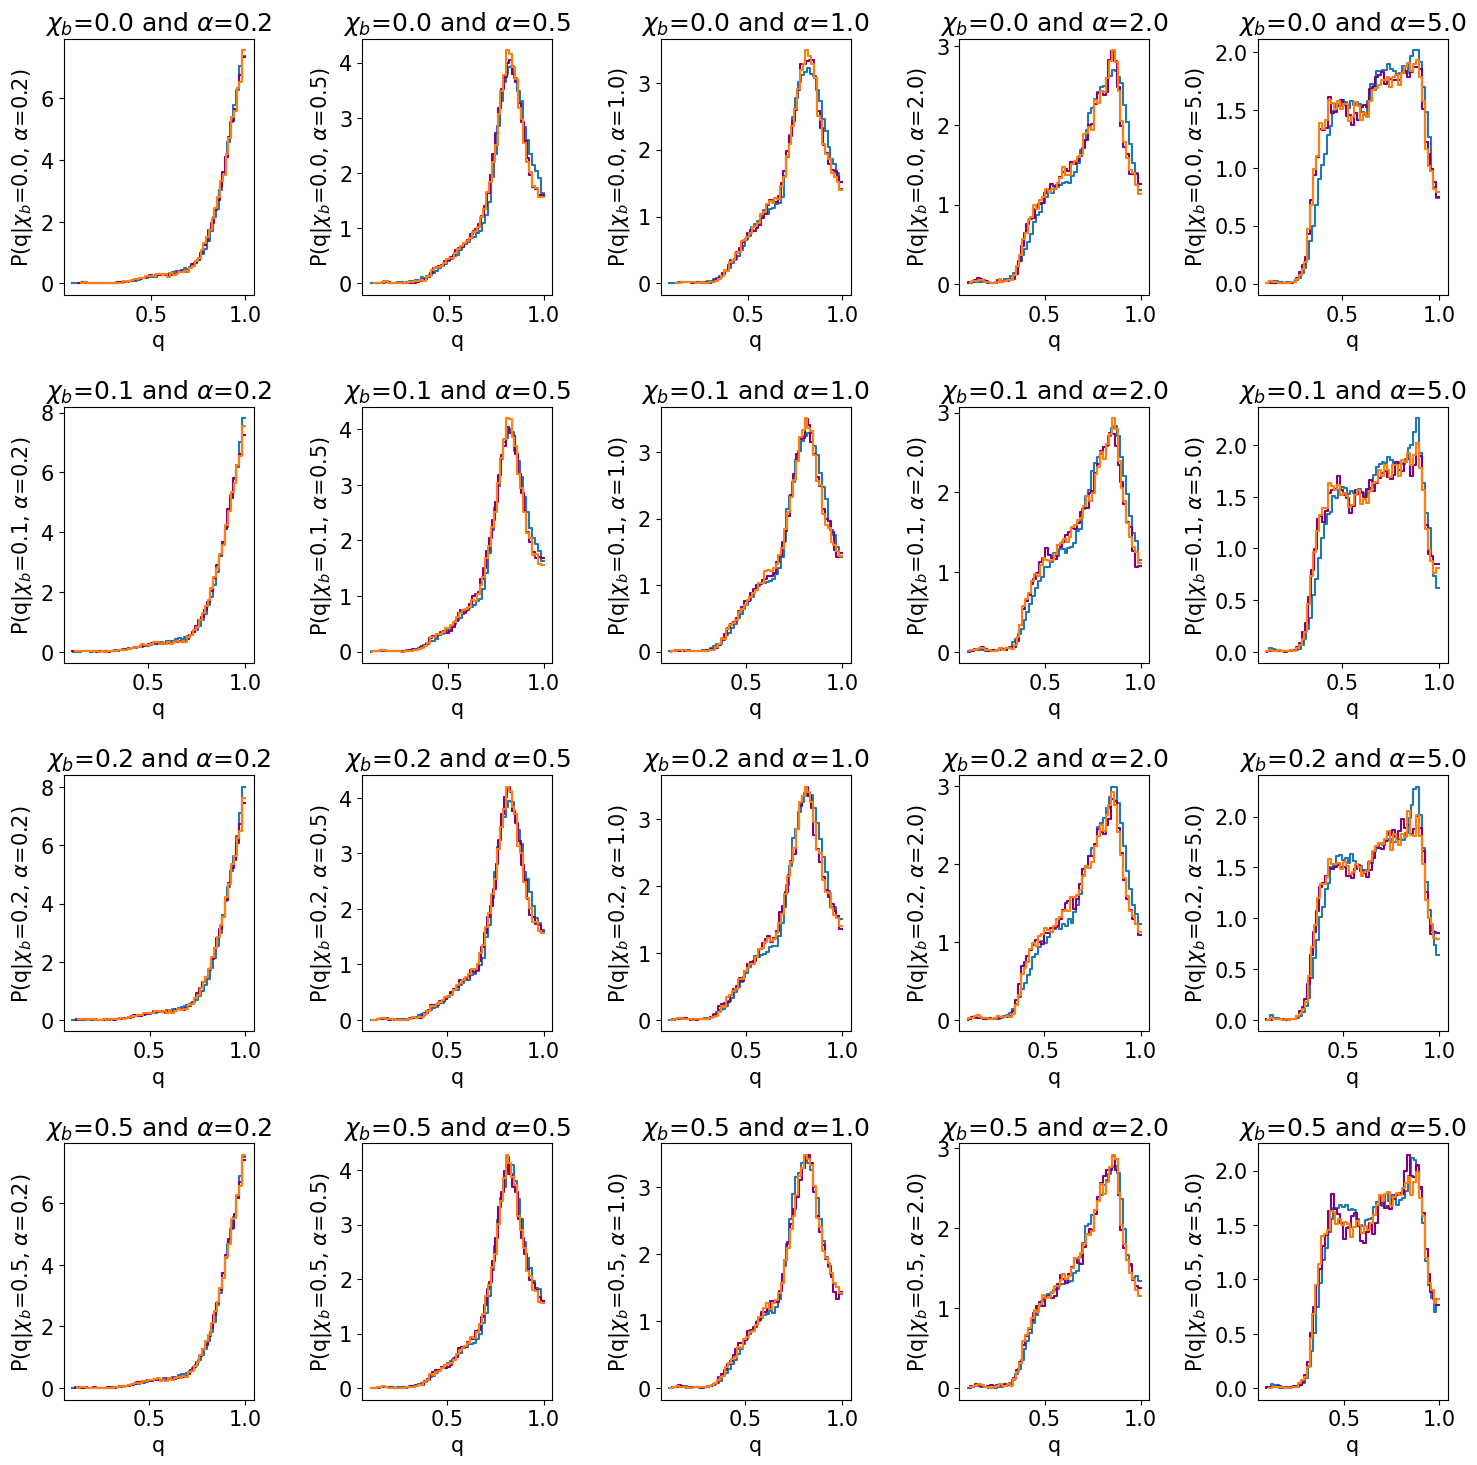

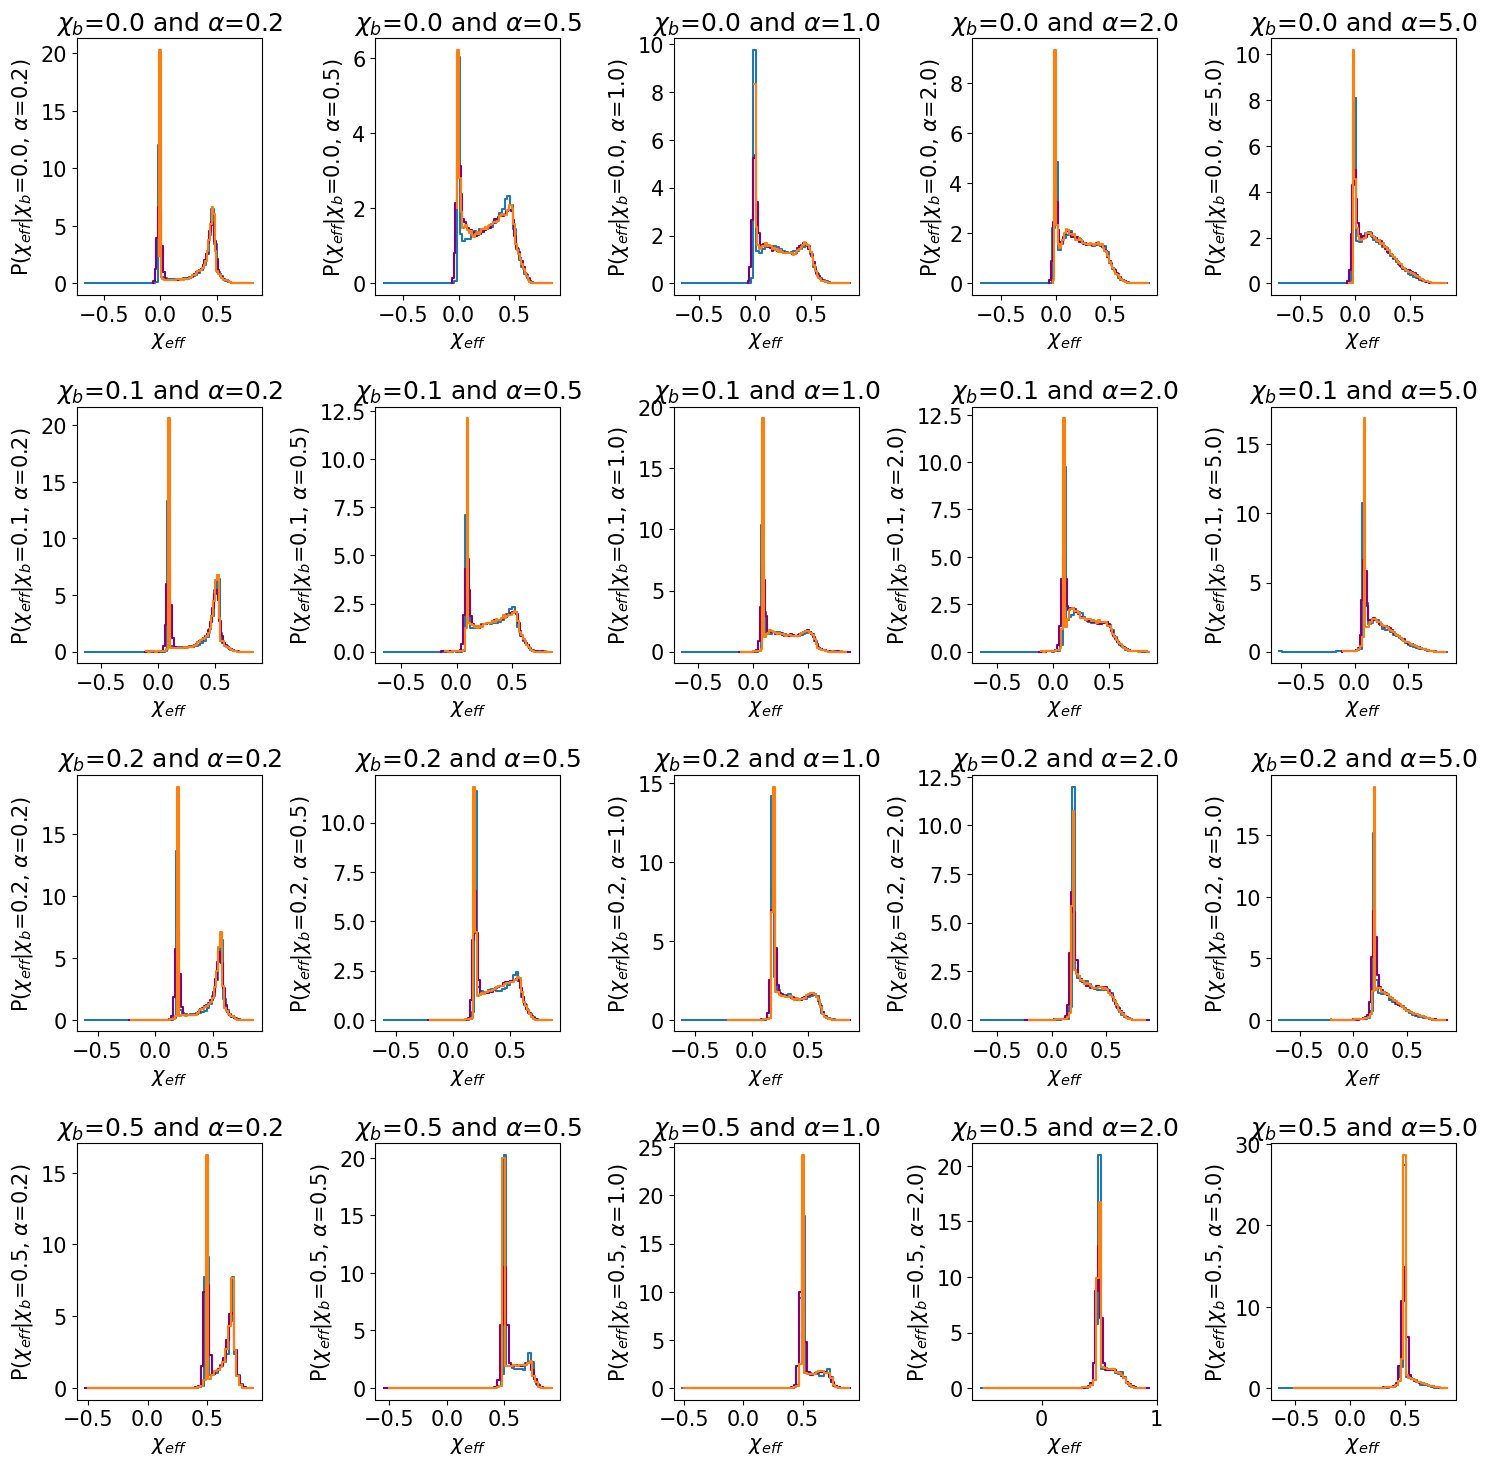

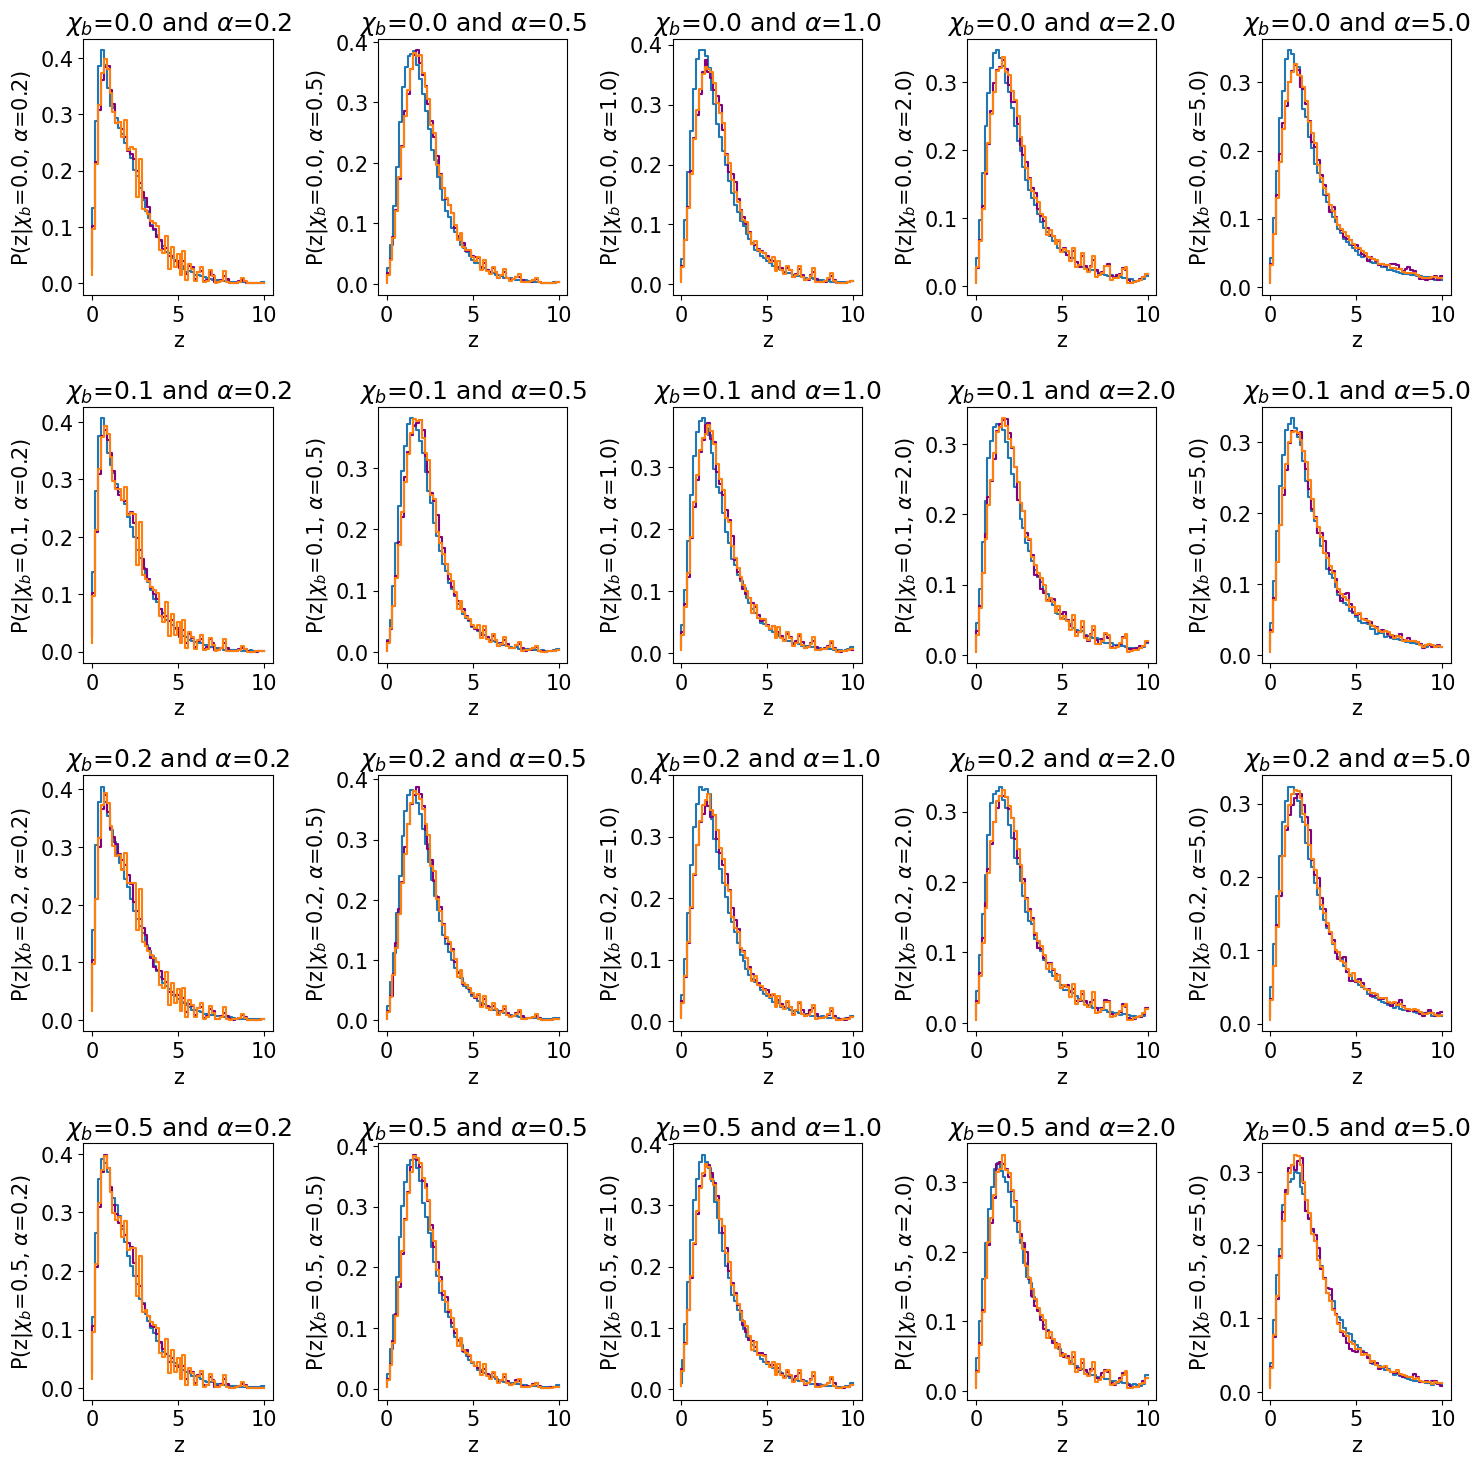

In [10]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = weighted_flow.flow.sample(np.array([xb,a]), no_samples)
        flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
        flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        kde_samples = KDE_models['CE'][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]].sample(no_samples)

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            kde_distr, bin_edges_KDE = np.histogram(kde_samples[:,i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id,alpha_id)][:])
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_KDE[0],bin_edges_KDE[-1],no_bins),kde_distr,label='KDE', color='purple')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].set_yscale('log')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

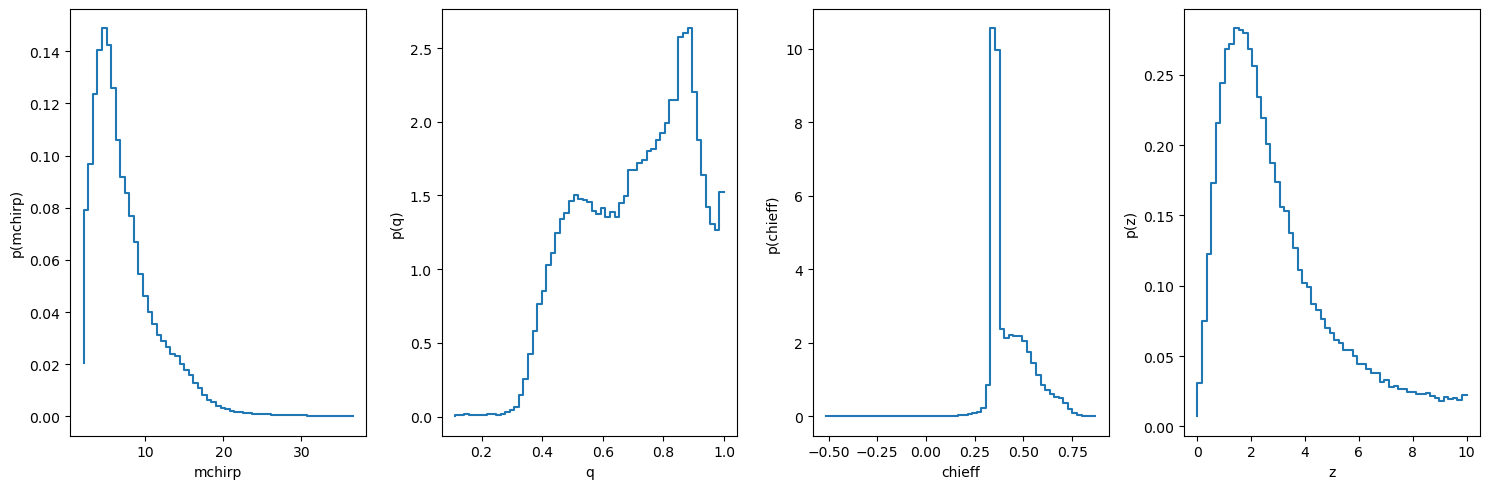

In [20]:
#checking example of flow interpolation
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 60

fig, ax = plt.subplots(1,4)

flow_samples_stack = weighted_flow.flow.sample(np.array([0.35, 3.0]),no_samples)
flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_chieff = np.tanh(flow_samples_stack[:,2])
flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

for i, p in enumerate(param):
    flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
    ax[i].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
    ax[i].set_xlabel(f'{p}')
    ax[i].set_ylabel(f'p({p})')
    plt.tight_layout()

## Corner Plots for 1 subpop

In [7]:
corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color="teal",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)

In [8]:
corner_kwargs_kde = dict(
    bins=64,
    smooth=0.9,
    color="purple",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)

## Corner plot CE

In [9]:
#sample flow
no_samples=100000
hyperparam_idxs = (1,3)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

flow_samples_stack = weighted_flow.flow.sample(np.array([0.1,2.]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])


kde_samples = KDE_models['CE'][submodels_dict[0][hyperparam_idxs[0]]][submodels_dict[1][hyperparam_idxs[1]]].sample(no_samples)

fig = corner.corner(flow_samples_stack.numpy(), **corner_kwargs)
fig =corner.corner(kde_samples, fig=fig, **corner_kwargs_kde)
fig =corner.corner(models_dict[hyperparam_idxs], fig=fig, weights=weights_dict[hyperparam_idxs][:], **kwargs)


NameError: name 'weighted_flow' is not defined

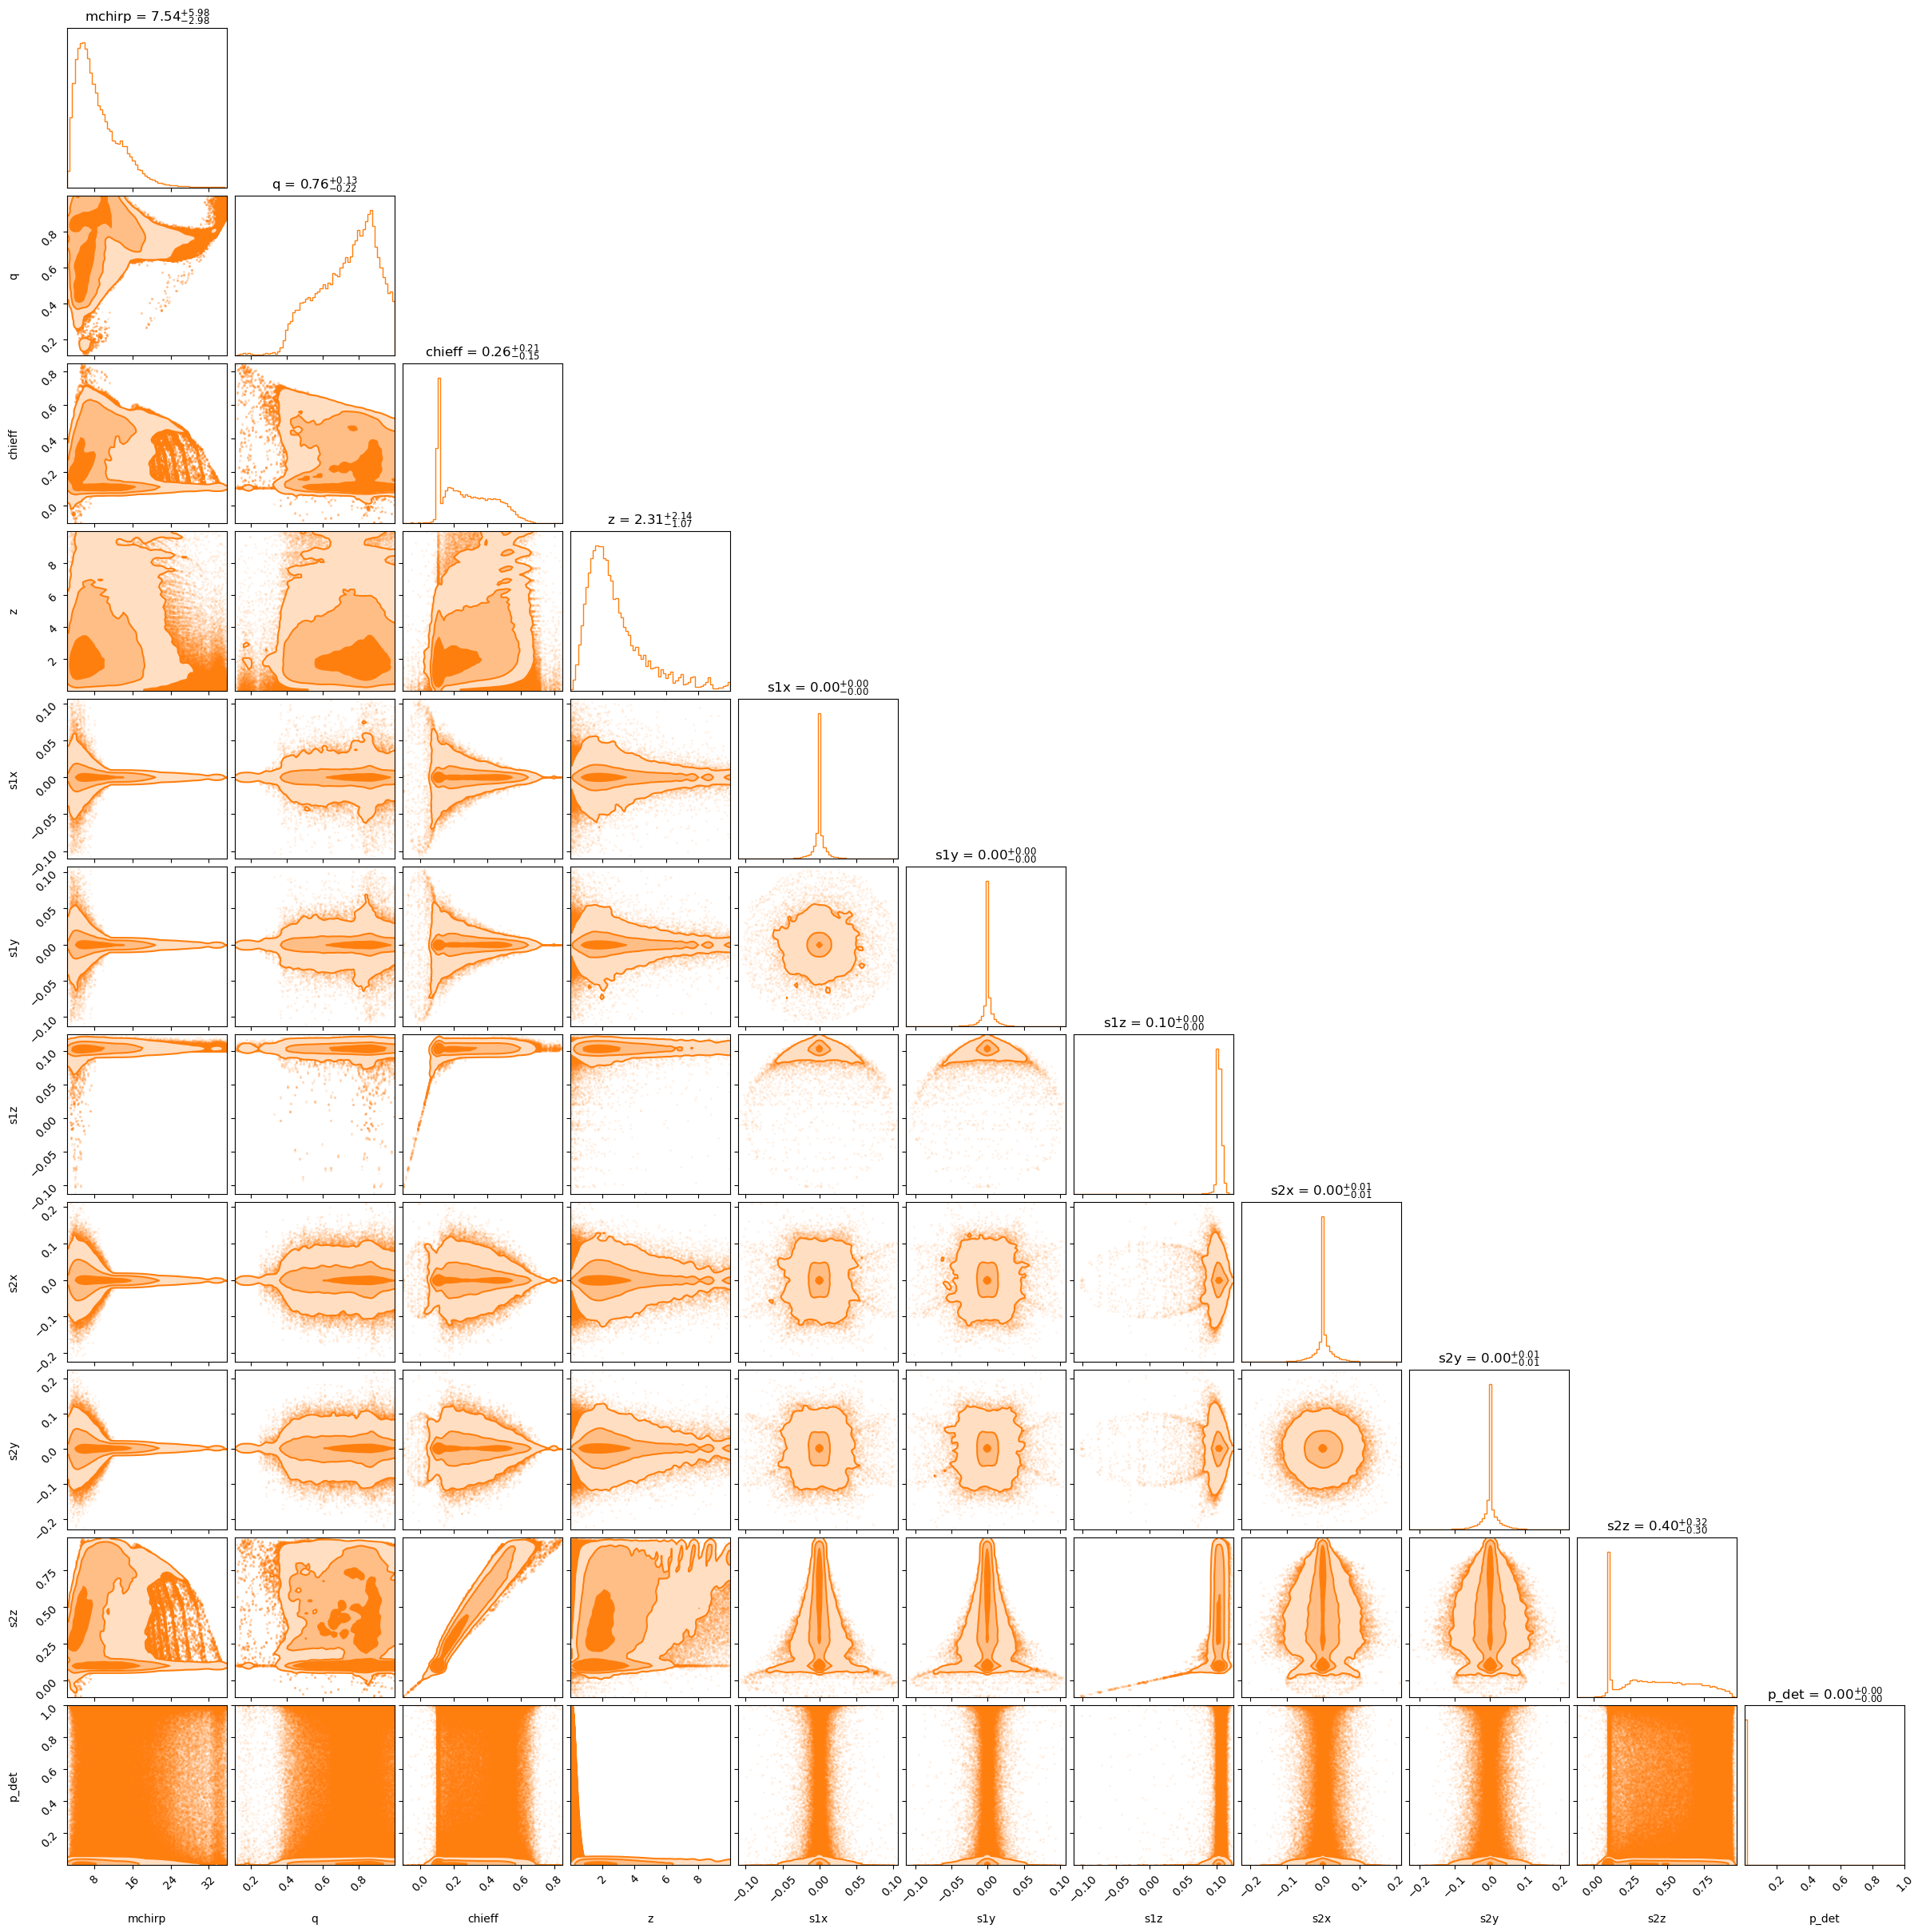

In [18]:
kwargs["labels"]=['mchirp','q','chieff','z', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'p_det']
fig =corner.corner(models_dict[hyperparam_idxs], weights=weights_dict[hyperparam_idxs][:], **kwargs)

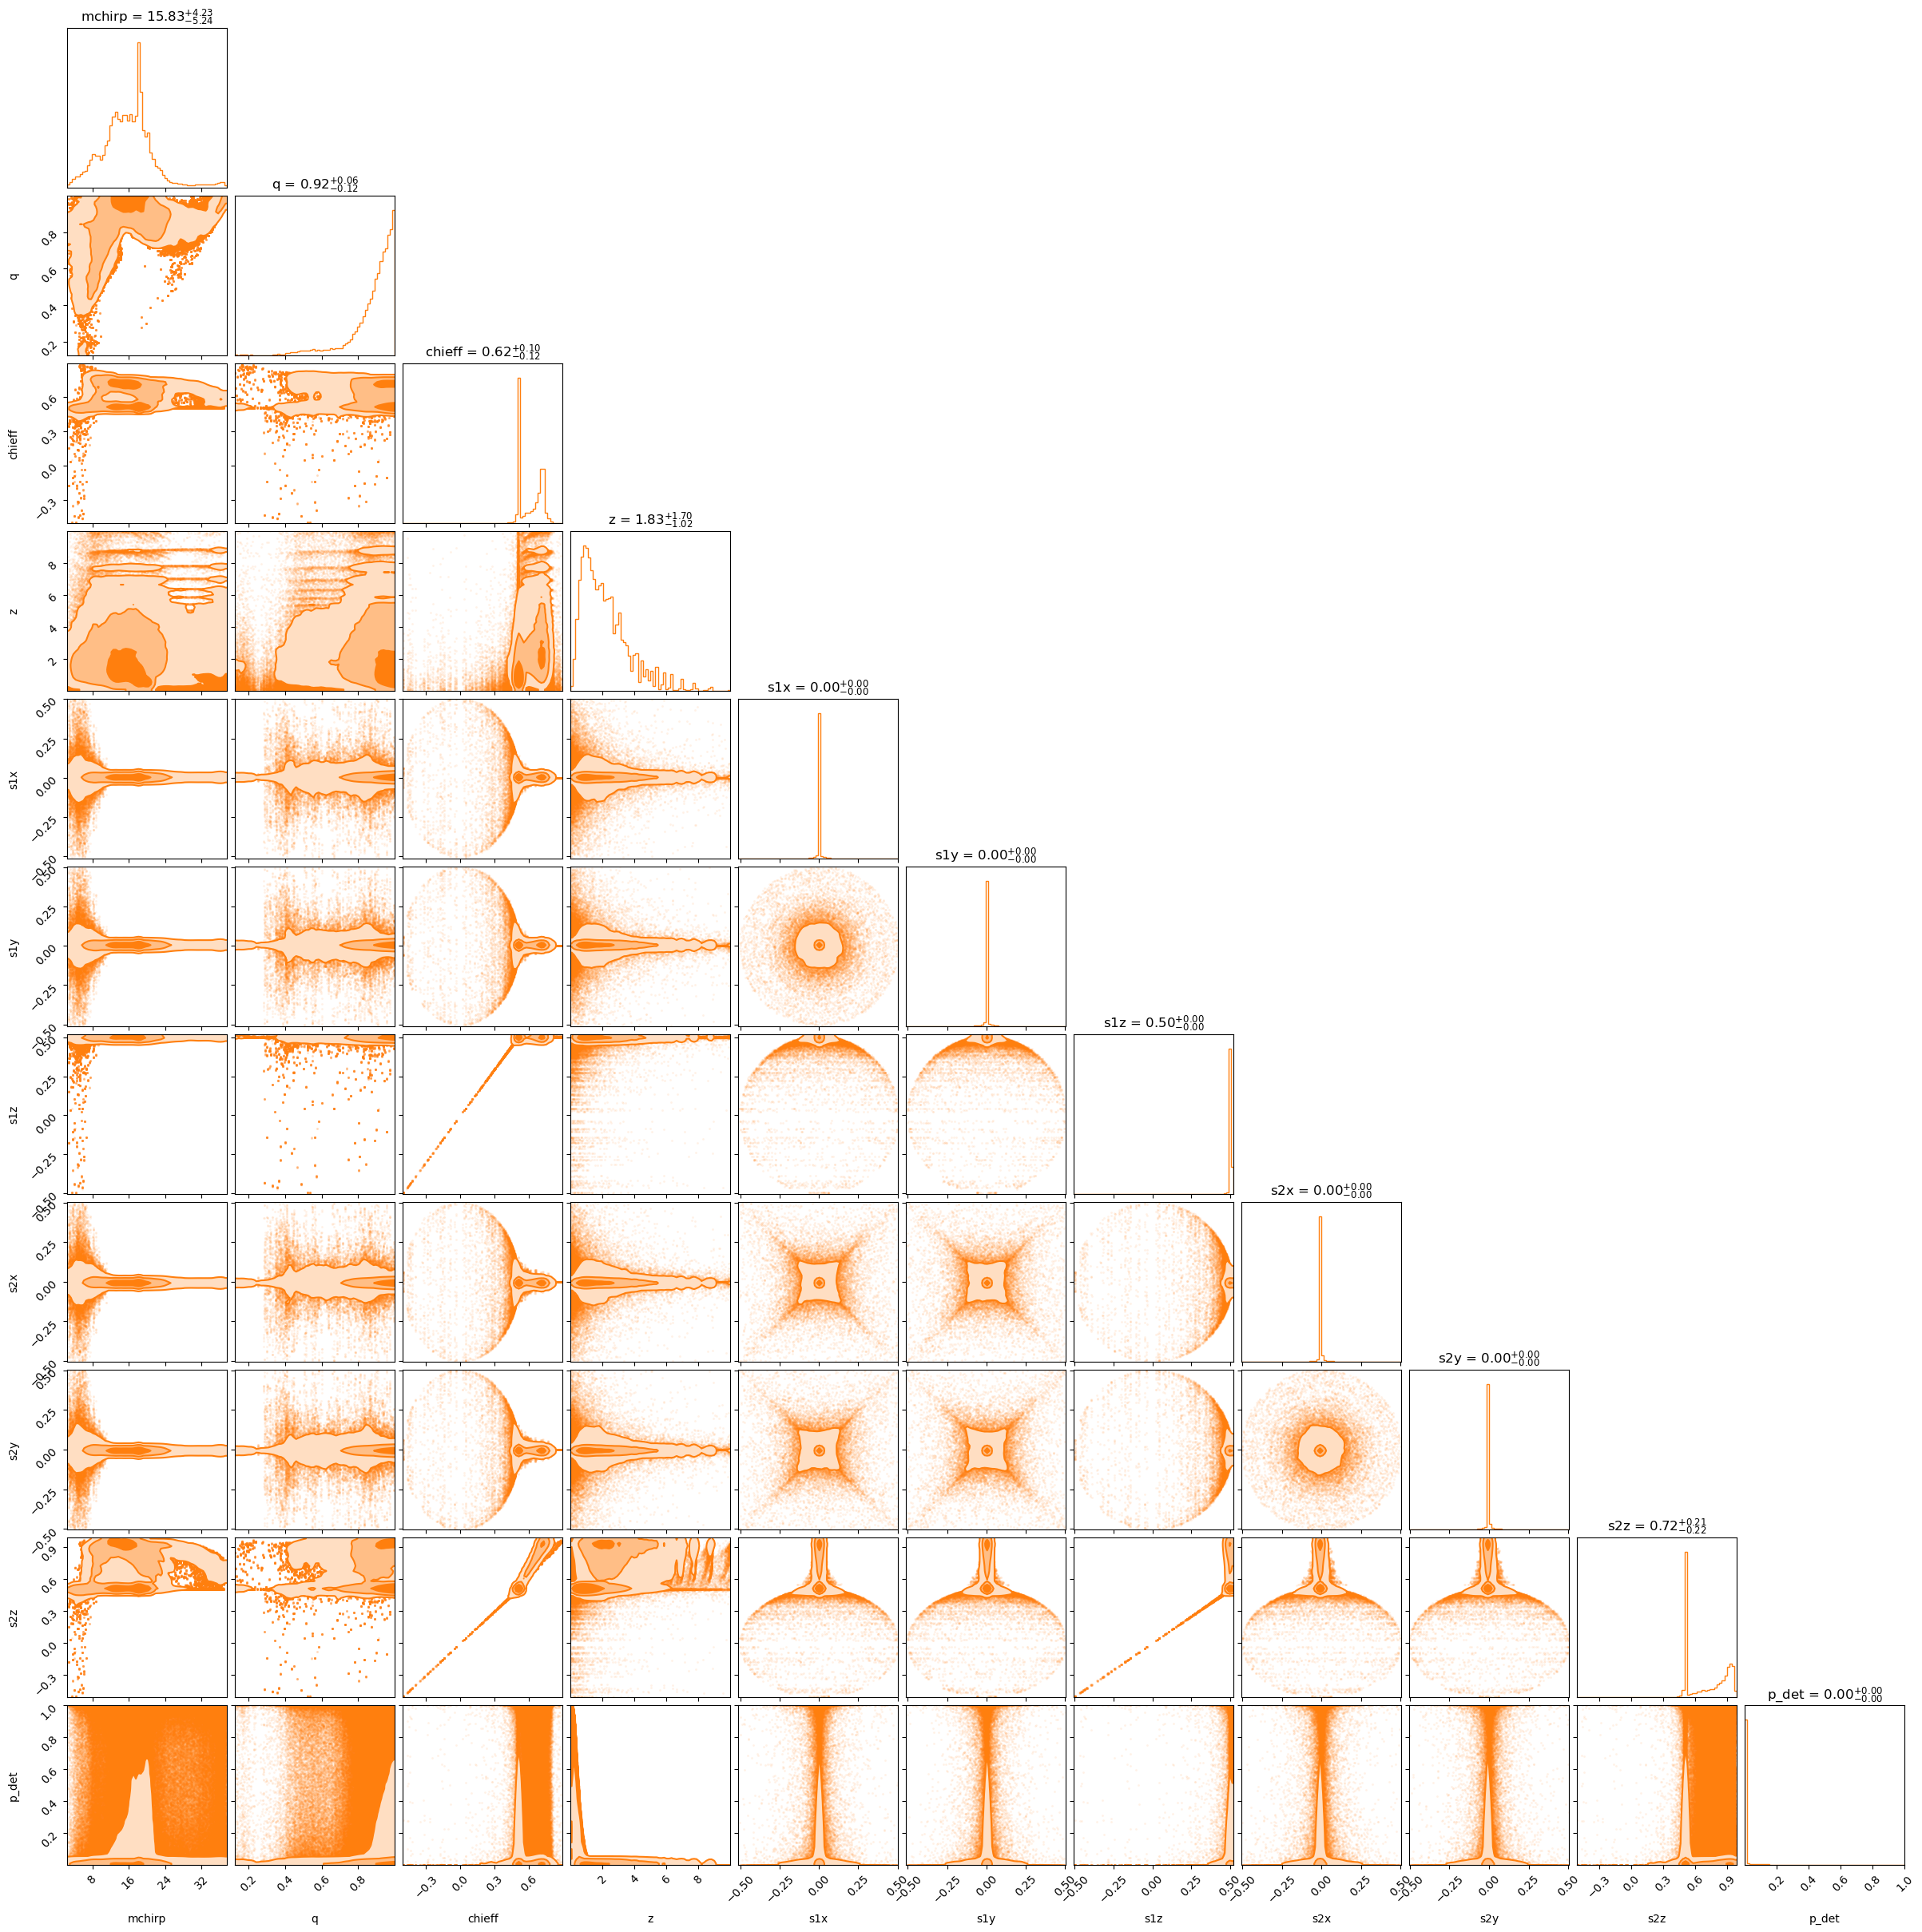

In [19]:
kwargs["labels"]=['mchirp','q','chieff','z', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'p_det']
hyperparam_idxs = (3,0)
fig =corner.corner(models_dict[hyperparam_idxs], weights=weights_dict[hyperparam_idxs][:], **kwargs)

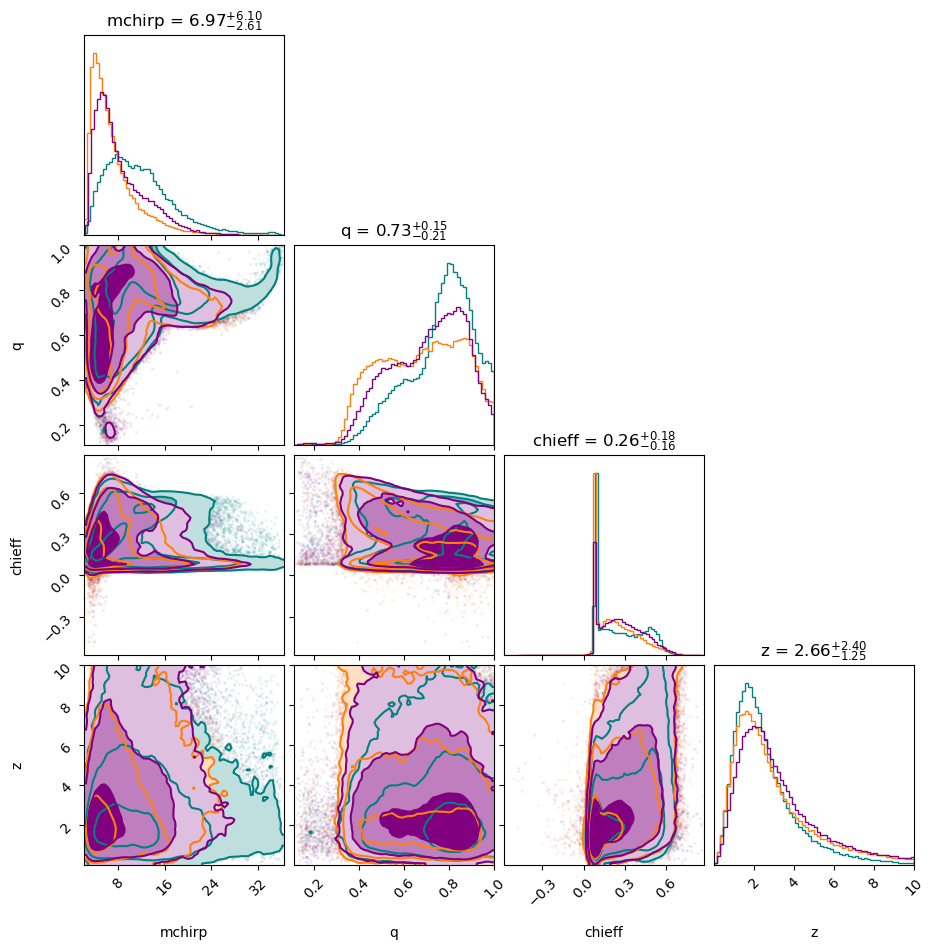

In [10]:
#sample flow
no_samples=100000
hyperparam_idxs = (0,2)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

flow_samples_stack = weighted_flow.flow.sample(np.array([0.08,1.0]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])
fig = corner.corner(flow_samples_stack.numpy(), **corner_kwargs)

flow_samples_stack = weighted_flow.flow.sample(np.array([0.08,5.0]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])
fig = corner.corner(flow_samples_stack.numpy(), fig=fig, **kwargs)

flow_samples_stack = weighted_flow.flow.sample(np.array([0.08,3.0]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])
fig = corner.corner(flow_samples_stack.numpy(), fig=fig, **corner_kwargs_kde)


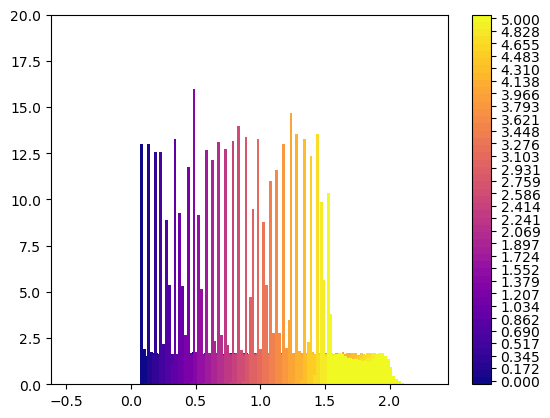

In [23]:
import matplotlib as mpl
#sample flow
no_samples=100000
hyperparam_idxs = (0,2)
cmap = plt.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 30))

for i,alpha_CE in enumerate(np.linspace(0.2,5.,30)):
    flow_samples_stack = weighted_flow.flow.sample(np.array([0.08,1.0]),no_samples)
    flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])+i*0.05
    plt.hist(flow_samples_stack[:,2].numpy(), density=True, bins=64, label=alpha_CE, color=colors[i])
    plt.ylim(0,20)

norm = mpl.colors.Normalize(vmin=0,vmax=5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,5,30), 
             boundaries=np.arange(-0.05,5.1,.1))

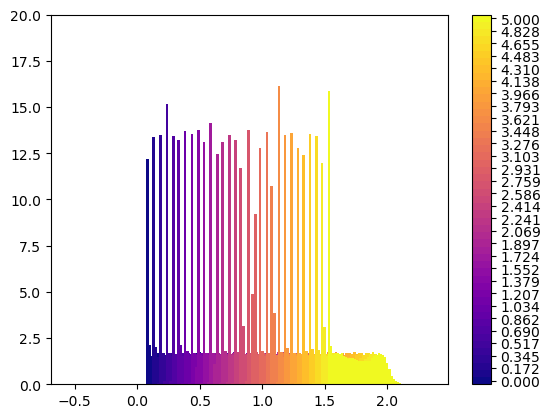

In [25]:
import matplotlib as mpl
#sample flow
no_samples=100000
hyperparam_idxs = (0,2)
cmap = plt.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 30))

for i,alpha_CE in enumerate(np.linspace(0.2,5.,30)):
    flow_samples_stack = weighted_flow.flow.sample(np.array([0.08,1.0]),no_samples)
    flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])+i*0.05
    plt.hist(flow_samples_stack[:,2].numpy(), density=True, bins=64, label=alpha_CE, color=colors[i])
    plt.ylim(0,20)

norm = mpl.colors.Normalize(vmin=0,vmax=5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,5,30), 
             boundaries=np.arange(-0.05,5.1,.1))

## Corner plot non-CE

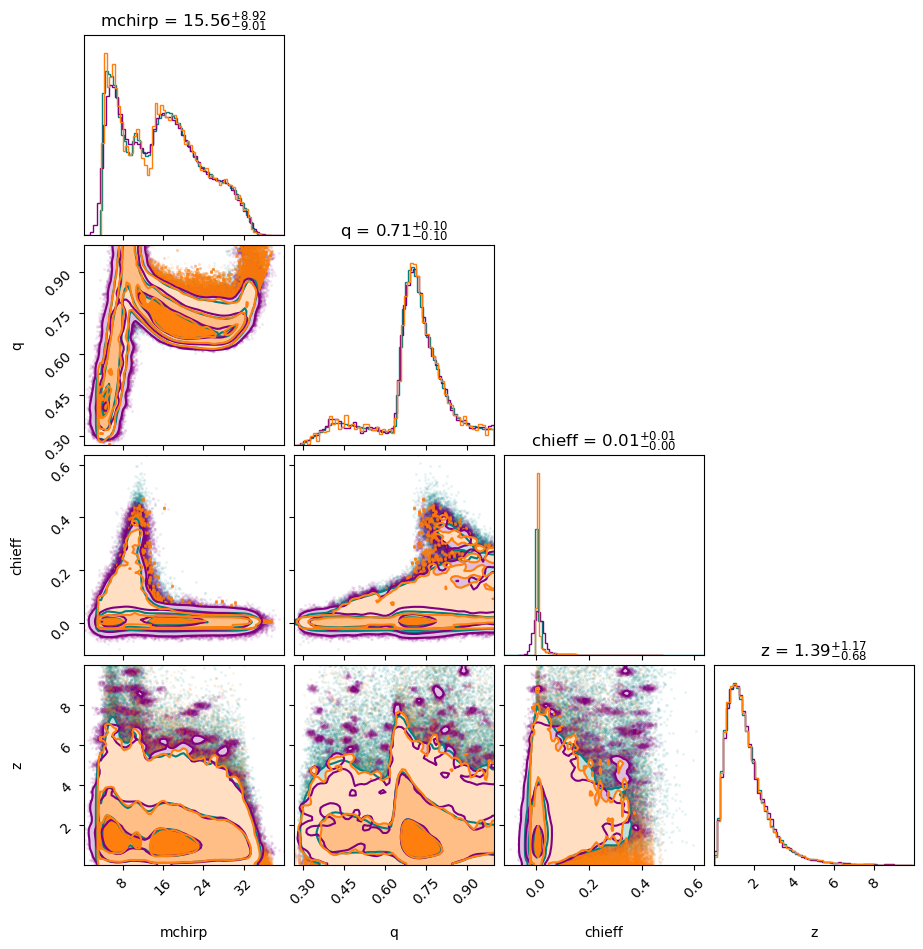

In [42]:
#sample flow
no_samples=1000000
hyperparam_idxs = (0)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"
kwargs["axes_scale"] = "log"

flow_samples_stack = weighted_flow.flow.sample(np.array([0.0]), no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])


kde_samples = KDE_models[channel_label][submodels_dict[0][hyperparam_idxs]].sample(no_samples)

fig = corner.corner(flow_samples_stack.numpy(), **corner_kwargs)
fig =corner.corner(kde_samples, fig=fig, **corner_kwargs_kde)
fig =corner.corner(models_dict[hyperparam_idxs], fig=fig, weights=weights_dict[hyperparam_idxs][:], **kwargs)

## Log corner plots of samples

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3983317107.py:30: RuntimeWarning: divide by zero encountered in log
  ax_flow[0,0].plot(mass_bins[:-1], np.log(np.histogram(flow_samples_stack[:,0].numpy(),mass_bins)[0]))
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3983317107.py:34: RuntimeWarning: divide by zero encountered in log
  ax_flow[2,2].plot(chieff_bins[:-1], np.log(np.histogram(flow_samples_stack[:,2].numpy(),chieff_bins)[0]))
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3983317107.py:39: RuntimeWarning: divide by zero encountered in log
  ax_flow[1,0].imshow(np.swapaxes(np.log(p_mchirpq_flow), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], q_bins[0], q_bins[-1]), aspect='auto')
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3983317107.py:40: RuntimeWarning: divide by zero encountered in log
  ax_flow[2,0].imshow(np.swapaxes(np.log(p_mchirpchieff_flow), axis1=0, axis2=1), origin

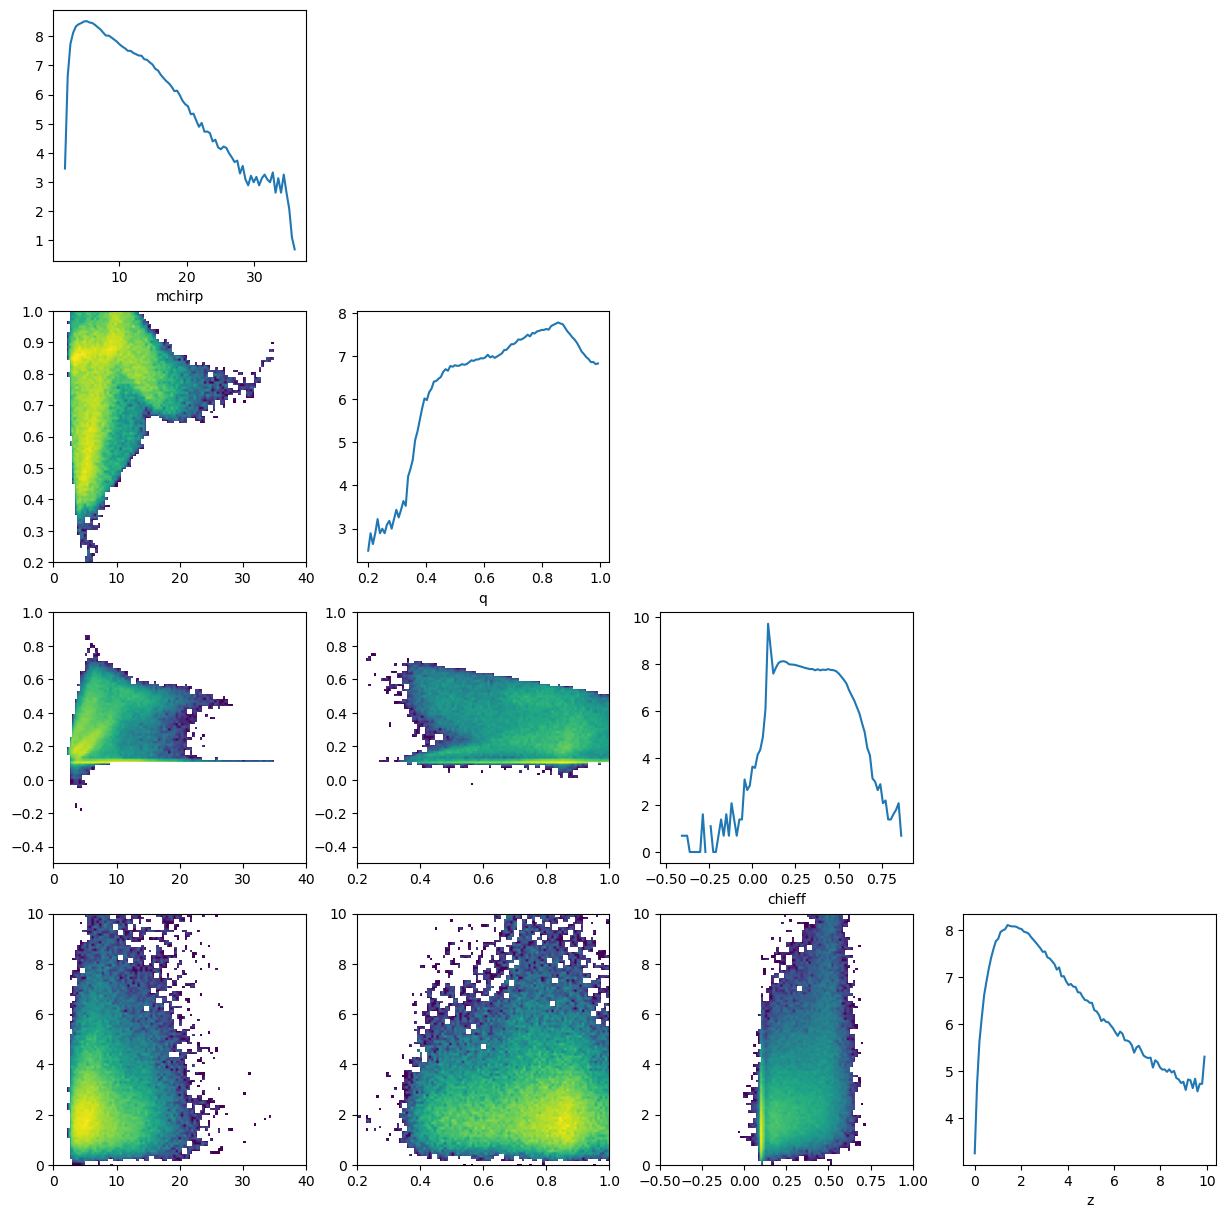

In [79]:
mass_bins=np.linspace(0,40,100)
q_bins=np.linspace(0.2,1.,100)
chieff_bins = np.linspace(-0.5,1.,100)
z_bins = np.linspace(0.,10.,100)

p_mchirpq_flow, p_mchirpq_flow_xs, p_mchirpq_flow_ys = np.histogram2d(flow_samples_stack[:,0].numpy(), flow_samples_stack[:,1].numpy(), bins=[mass_bins,q_bins])
p_mchirpq_KDE, p_mchirpq_KDE_xs, p_mchirpq_KDE_ys = np.histogram2d(kde_samples[:,0], kde_samples[:,1], bins=[mass_bins,q_bins])
p_mchirpchieff_flow, _, _ = np.histogram2d(flow_samples_stack[:,0].numpy(), flow_samples_stack[:,2].numpy(), bins=[mass_bins,chieff_bins])
p_mchirpchieff_KDE, _, _ = np.histogram2d(kde_samples[:,0], kde_samples[:,2], bins=[mass_bins,chieff_bins])
p_mchirpz_flow, _, _ = np.histogram2d(flow_samples_stack[:,0].numpy(), flow_samples_stack[:,3].numpy(), bins=[mass_bins,z_bins])
p_mchirpz_KDE, _, _ = np.histogram2d(kde_samples[:,0], kde_samples[:,3], bins=[mass_bins,z_bins])

p_qchieff_flow, _, _ = np.histogram2d(flow_samples_stack[:,1].numpy(), flow_samples_stack[:,2].numpy(), bins=[q_bins,chieff_bins])
p_qchieff_KDE, _, _ = np.histogram2d(kde_samples[:,1], kde_samples[:,2], bins=[q_bins,chieff_bins])
p_qz_flow, _, _ = np.histogram2d(flow_samples_stack[:,1].numpy(), flow_samples_stack[:,3].numpy(), bins=[q_bins,z_bins])
p_qz_KDE, _, _ = np.histogram2d(kde_samples[:,1], kde_samples[:,3], bins=[q_bins,z_bins])

p_chieffz_flow, _, _ = np.histogram2d(flow_samples_stack[:,2].numpy(), flow_samples_stack[:,3].numpy(), bins=[chieff_bins,z_bins])
p_chieffz_KDE, _, _ = np.histogram2d(kde_samples[:,2], kde_samples[:,3], bins=[chieff_bins,z_bins])

plt.rcParams["figure.figsize"] = (15,15)
fig_flow,ax_flow=plt.subplots(4,4)
ax_flow[0,1].set_axis_off()
ax_flow[0,2].set_axis_off()
ax_flow[1,2].set_axis_off()
ax_flow[0,3].set_axis_off()
ax_flow[1,3].set_axis_off()
ax_flow[2,3].set_axis_off()

ax_flow[0,0].plot(mass_bins[:-1], np.log(np.histogram(flow_samples_stack[:,0].numpy(),mass_bins)[0]))
ax_flow[0,0].set_xlabel('mchirp')
ax_flow[1,1].plot(q_bins[:-1], np.log(np.histogram(flow_samples_stack[:,1].numpy(),q_bins)[0]))
ax_flow[1,1].set_xlabel('q')
ax_flow[2,2].plot(chieff_bins[:-1], np.log(np.histogram(flow_samples_stack[:,2].numpy(),chieff_bins)[0]))
ax_flow[2,2].set_xlabel('chieff')
ax_flow[3,3].plot(z_bins[:-1], np.log(np.histogram(flow_samples_stack[:,3].numpy(),z_bins)[0]))
ax_flow[3,3].set_xlabel('z')

ax_flow[1,0].imshow(np.swapaxes(np.log(p_mchirpq_flow), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], q_bins[0], q_bins[-1]), aspect='auto')
ax_flow[2,0].imshow(np.swapaxes(np.log(p_mchirpchieff_flow), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], chieff_bins[0], chieff_bins[-1]), aspect='auto')
ax_flow[3,0].imshow(np.swapaxes(np.log(p_mchirpz_flow), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')
ax_flow[2,1].imshow(np.swapaxes(np.log(p_qchieff_flow), axis1=0, axis2=1), origin='lower',extent=(q_bins[0], q_bins[-1], chieff_bins[0], chieff_bins[-1]), aspect='auto')
ax_flow[3,1].imshow(np.swapaxes(np.log(p_qz_flow), axis1=0, axis2=1), origin='lower',extent=(q_bins[0], q_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')
ax_flow[3,2].imshow(np.swapaxes(np.log(p_chieffz_flow), axis1=0, axis2=1), origin='lower',extent=(chieff_bins[0], chieff_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/907891538.py:10: RuntimeWarning: divide by zero encountered in log
  ax_kde[0,0].plot(mass_bins[:-1], np.log(np.histogram(kde_samples[:,0],mass_bins)[0]))
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/907891538.py:14: RuntimeWarning: divide by zero encountered in log
  ax_kde[2,2].plot(chieff_bins[:-1], np.log(np.histogram(kde_samples[:,2],chieff_bins)[0]))
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/907891538.py:19: RuntimeWarning: divide by zero encountered in log
  ax_kde[1,0].imshow(np.swapaxes(np.log(p_mchirpq_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], q_bins[0], q_bins[-1]), aspect='auto')
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/907891538.py:20: RuntimeWarning: divide by zero encountered in log
  ax_kde[2,0].imshow(np.swapaxes(np.log(p_mchirpchieff_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins

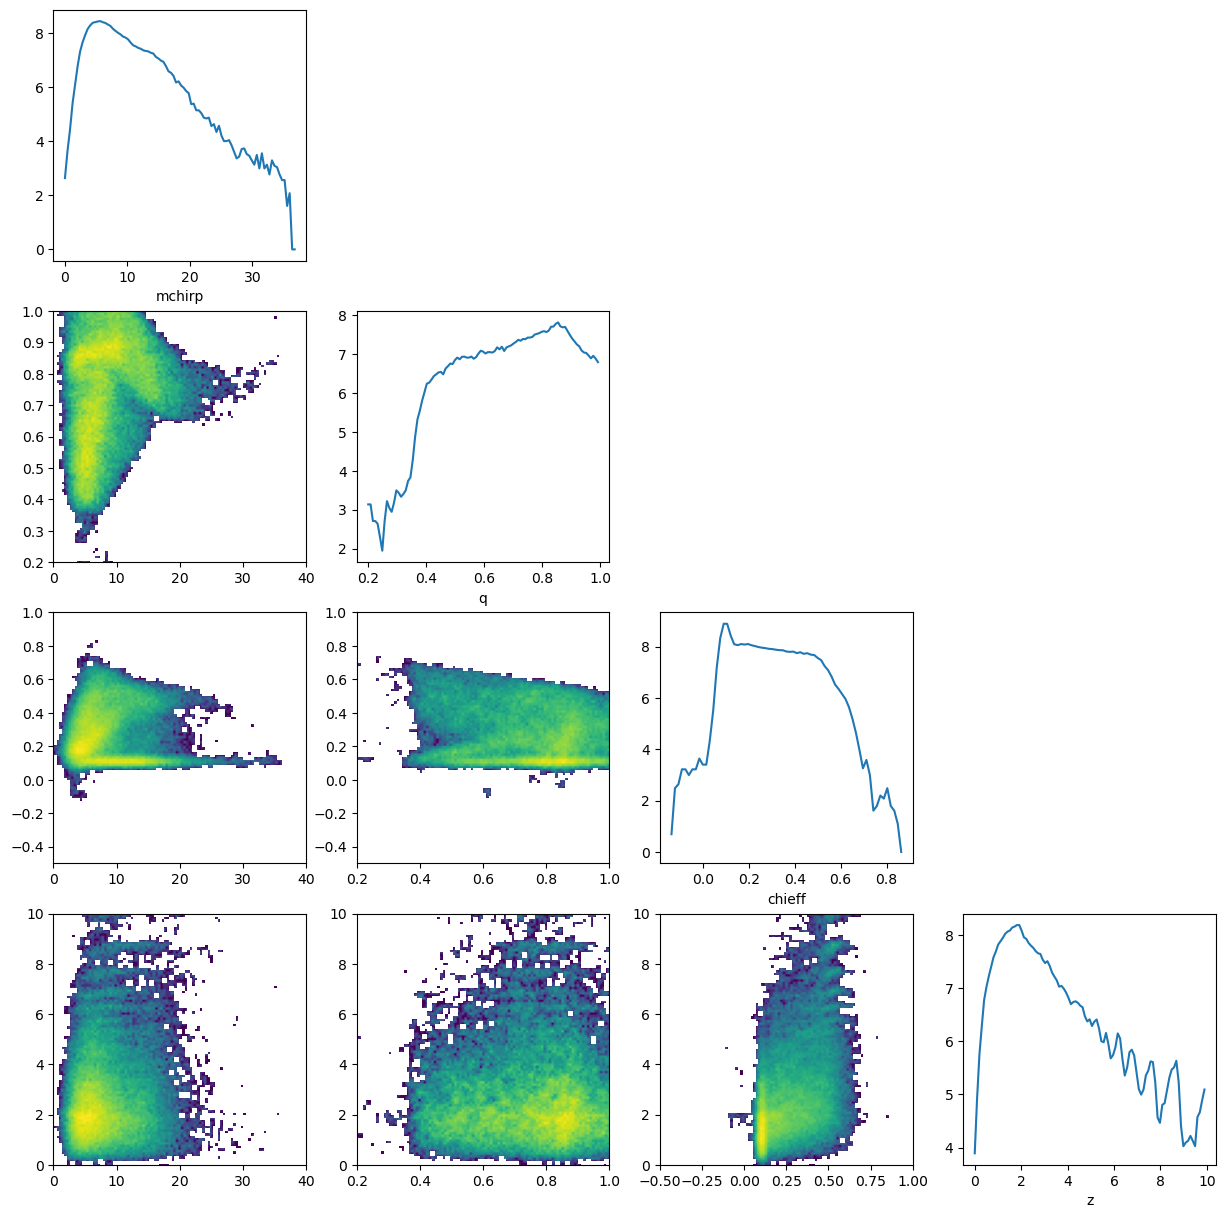

In [80]:
plt.rcParams["figure.figsize"] = (15,15)
fig_kde,ax_kde=plt.subplots(4,4)
ax_kde[0,1].set_axis_off()
ax_kde[0,2].set_axis_off()
ax_kde[1,2].set_axis_off()
ax_kde[0,3].set_axis_off()
ax_kde[1,3].set_axis_off()
ax_kde[2,3].set_axis_off()

ax_kde[0,0].plot(mass_bins[:-1], np.log(np.histogram(kde_samples[:,0],mass_bins)[0]))
ax_kde[0,0].set_xlabel('mchirp')
ax_kde[1,1].plot(q_bins[:-1], np.log(np.histogram(kde_samples[:,1],q_bins)[0]))
ax_kde[1,1].set_xlabel('q')
ax_kde[2,2].plot(chieff_bins[:-1], np.log(np.histogram(kde_samples[:,2],chieff_bins)[0]))
ax_kde[2,2].set_xlabel('chieff')
ax_kde[3,3].plot(z_bins[:-1], np.log(np.histogram(kde_samples[:,3],z_bins)[0]))
ax_kde[3,3].set_xlabel('z')

ax_kde[1,0].imshow(np.swapaxes(np.log(p_mchirpq_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], q_bins[0], q_bins[-1]), aspect='auto')
ax_kde[2,0].imshow(np.swapaxes(np.log(p_mchirpchieff_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], chieff_bins[0], chieff_bins[-1]), aspect='auto')
ax_kde[3,0].imshow(np.swapaxes(np.log(p_mchirpz_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')
ax_kde[2,1].imshow(np.swapaxes(np.log(p_qchieff_KDE), axis1=0, axis2=1), origin='lower',extent=(q_bins[0], q_bins[-1], chieff_bins[0], chieff_bins[-1]), aspect='auto')
ax_kde[3,1].imshow(np.swapaxes(np.log(p_qz_KDE), axis1=0, axis2=1), origin='lower',extent=(q_bins[0], q_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')
ax_kde[3,2].imshow(np.swapaxes(np.log(p_chieffz_KDE), axis1=0, axis2=1), origin='lower',extent=(chieff_bins[0], chieff_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3596008311.py:30: RuntimeWarning: divide by zero encountered in log
  ax_flow[0,0].plot(mass_bins[:-1], np.log(np.histogram(flow_samples_stack[:,0].numpy(),mass_bins)[0])-np.log(np.histogram(kde_samples[:,0],mass_bins)[0]))
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3596008311.py:30: RuntimeWarning: invalid value encountered in subtract
  ax_flow[0,0].plot(mass_bins[:-1], np.log(np.histogram(flow_samples_stack[:,0].numpy(),mass_bins)[0])-np.log(np.histogram(kde_samples[:,0],mass_bins)[0]))
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3596008311.py:34: RuntimeWarning: divide by zero encountered in log
  ax_flow[2,2].plot(chieff_bins[:-1], np.log(np.histogram(flow_samples_stack[:,2].numpy(),chieff_bins)[0])-np.log(np.histogram(kde_samples[:,2],chieff_bins)[0]))
/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_90272/3596008311.py:34: RuntimeWarning: invalid value encountere

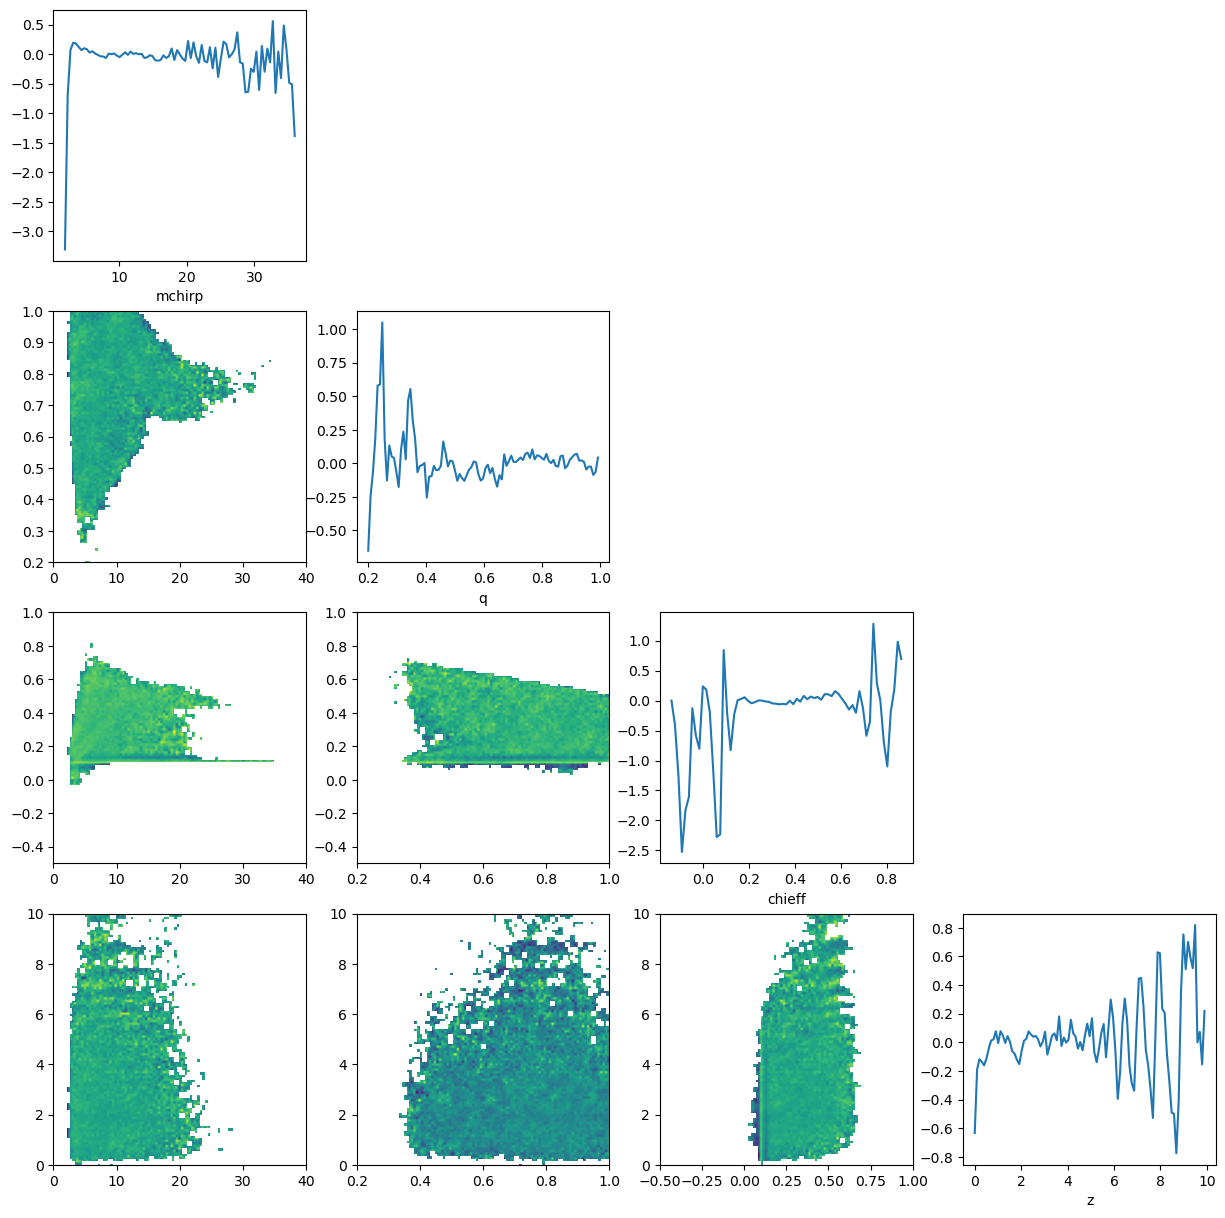

In [81]:
mass_bins=np.linspace(0,40,100)
q_bins=np.linspace(0.2,1.,100)
chieff_bins = np.linspace(-0.5,1.,100)
z_bins = np.linspace(0.,10.,100)

p_mchirpq_flow, p_mchirpq_flow_xs, p_mchirpq_flow_ys = np.histogram2d(flow_samples_stack[:,0].numpy(), flow_samples_stack[:,1].numpy(), bins=[mass_bins,q_bins])
p_mchirpq_KDE, p_mchirpq_KDE_xs, p_mchirpq_KDE_ys = np.histogram2d(kde_samples[:,0], kde_samples[:,1], bins=[mass_bins,q_bins])
p_mchirpchieff_flow, _, _ = np.histogram2d(flow_samples_stack[:,0].numpy(), flow_samples_stack[:,2].numpy(), bins=[mass_bins,chieff_bins])
p_mchirpchieff_KDE, _, _ = np.histogram2d(kde_samples[:,0], kde_samples[:,2], bins=[mass_bins,chieff_bins])
p_mchirpz_flow, _, _ = np.histogram2d(flow_samples_stack[:,0].numpy(), flow_samples_stack[:,3].numpy(), bins=[mass_bins,z_bins])
p_mchirpz_KDE, _, _ = np.histogram2d(kde_samples[:,0], kde_samples[:,3], bins=[mass_bins,z_bins])

p_qchieff_flow, _, _ = np.histogram2d(flow_samples_stack[:,1].numpy(), flow_samples_stack[:,2].numpy(), bins=[q_bins,chieff_bins])
p_qchieff_KDE, _, _ = np.histogram2d(kde_samples[:,1], kde_samples[:,2], bins=[q_bins,chieff_bins])
p_qz_flow, _, _ = np.histogram2d(flow_samples_stack[:,1].numpy(), flow_samples_stack[:,3].numpy(), bins=[q_bins,z_bins])
p_qz_KDE, _, _ = np.histogram2d(kde_samples[:,1], kde_samples[:,3], bins=[q_bins,z_bins])

p_chieffz_flow, _, _ = np.histogram2d(flow_samples_stack[:,2].numpy(), flow_samples_stack[:,3].numpy(), bins=[chieff_bins,z_bins])
p_chieffz_KDE, _, _ = np.histogram2d(kde_samples[:,2], kde_samples[:,3], bins=[chieff_bins,z_bins])

plt.rcParams["figure.figsize"] = (15,15)
fig_flow,ax_flow=plt.subplots(4,4)
ax_flow[0,1].set_axis_off()
ax_flow[0,2].set_axis_off()
ax_flow[1,2].set_axis_off()
ax_flow[0,3].set_axis_off()
ax_flow[1,3].set_axis_off()
ax_flow[2,3].set_axis_off()

ax_flow[0,0].plot(mass_bins[:-1], np.log(np.histogram(flow_samples_stack[:,0].numpy(),mass_bins)[0])-np.log(np.histogram(kde_samples[:,0],mass_bins)[0]))
ax_flow[0,0].set_xlabel('mchirp')
ax_flow[1,1].plot(q_bins[:-1], np.log(np.histogram(flow_samples_stack[:,1].numpy(),q_bins)[0])-np.log(np.histogram(kde_samples[:,1],q_bins)[0]))
ax_flow[1,1].set_xlabel('q')
ax_flow[2,2].plot(chieff_bins[:-1], np.log(np.histogram(flow_samples_stack[:,2].numpy(),chieff_bins)[0])-np.log(np.histogram(kde_samples[:,2],chieff_bins)[0]))
ax_flow[2,2].set_xlabel('chieff')
ax_flow[3,3].plot(z_bins[:-1], np.log(np.histogram(flow_samples_stack[:,3].numpy(),z_bins)[0])-np.log(np.histogram(kde_samples[:,3],z_bins)[0]))
ax_flow[3,3].set_xlabel('z')

ax_flow[1,0].imshow(np.swapaxes(np.log(p_mchirpq_flow)-np.log(p_mchirpq_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], q_bins[0], q_bins[-1]), aspect='auto')
ax_flow[2,0].imshow(np.swapaxes(np.log(p_mchirpchieff_flow)-np.log(p_mchirpchieff_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], chieff_bins[0], chieff_bins[-1]), aspect='auto')
ax_flow[3,0].imshow(np.swapaxes(np.log(p_mchirpz_flow)-np.log(p_mchirpz_KDE), axis1=0, axis2=1), origin='lower',extent=(mass_bins[0], mass_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')
ax_flow[2,1].imshow(np.swapaxes(np.log(p_qchieff_flow)-np.log(p_qchieff_KDE), axis1=0, axis2=1), origin='lower',extent=(q_bins[0], q_bins[-1], chieff_bins[0], chieff_bins[-1]), aspect='auto')
ax_flow[3,1].imshow(np.swapaxes(np.log(p_qz_flow)-np.log(p_qz_KDE), axis1=0, axis2=1), origin='lower',extent=(q_bins[0], q_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')
ax_flow[3,2].imshow(np.swapaxes(np.log(p_chieffz_flow)-np.log(p_chieffz_KDE), axis1=0, axis2=1), origin='lower',extent=(chieff_bins[0], chieff_bins[-1], z_bins[0], z_bins[-1]), aspect='auto')

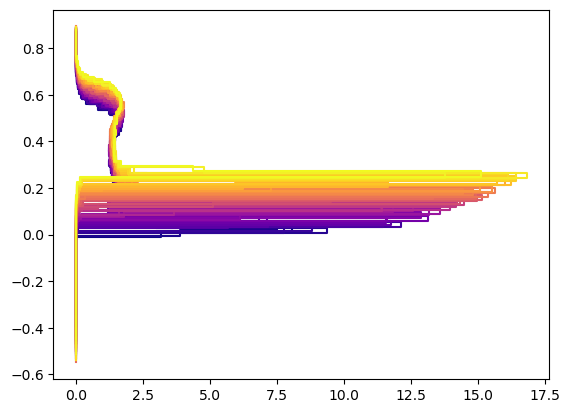

In [24]:
#sample flow
no_samples=100000
hyperparam_idxs = (0,2)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

cmap = plt.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 50))
flow_samples_stack = np.zeros((50, no_samples, 4))

for cb, chi_b in enumerate(np.linspace(0.,0.25,50)):
    flow_samples_stack[cb,:,:] = weighted_flow.flow.sample(np.array([chi_b,1.0]),no_samples)
    flow_samples_stack[cb,:,2] = np.tanh(flow_samples_stack[cb,:,2])
    hist, bin_edges = np.histogram(flow_samples_stack[cb,:,2], bins=60, density=True)
    plt.step(hist, np.linspace(bin_edges[0],bin_edges[-1],60), color=colors[cb])

flow_samples_chib0 = weighted_flow.flow.sample(np.array([0.,1.0]),no_samples)
flow_samples_chib01 = weighted_flow.flow.sample(np.array([0.1,1.0]),no_samples)
flow_samples_chib02 = weighted_flow.flow.sample(np.array([0.2,1.0]),no_samples)
flow_samples_chib0[:,2] = np.tanh(flow_samples_chib0[:,2])
flow_samples_chib01[:,2] = np.tanh(flow_samples_chib01[:,2])
flow_samples_chib02[:,2] = np.tanh(flow_samples_chib02[:,2])

(array([7.18907491e-04, 0.00000000e+00, 0.00000000e+00, 7.18905950e-04,
        2.15672247e-03, 7.18907491e-04, 0.00000000e+00, 2.15672247e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.18907491e-04,
        1.43781498e-03, 1.43781498e-03, 7.18907491e-04, 0.00000000e+00,
        2.15672247e-03, 1.43781190e-03, 1.43781652e-03, 2.15672016e-03,
        7.18907491e-04, 0.00000000e+00, 7.18907491e-04, 7.18906721e-04,
        7.18907491e-04, 0.00000000e+00, 7.18906721e-04, 2.15672247e-03,
        0.00000000e+00, 2.15672132e-03, 0.00000000e+00, 2.15672132e-03,
        7.18907298e-04, 1.43781460e-03, 7.18907298e-04, 1.43781450e-03,
        1.43781450e-03, 7.18907298e-04, 8.62688642e-03, 7.18907298e-03,
        1.43781460e-03, 9.34579237e-03, 7.90798240e-03, 1.22214208e-02,
        1.50970573e-02, 2.22861203e-02, 2.65995772e-02, 3.66642820e-02,
        6.25448847e-02, 1.49532758e-01, 8.95758733e-01, 2.54658328e+01,
        1.91660737e+00, 1.71675109e+00, 1.63623170e+00, 1.593099

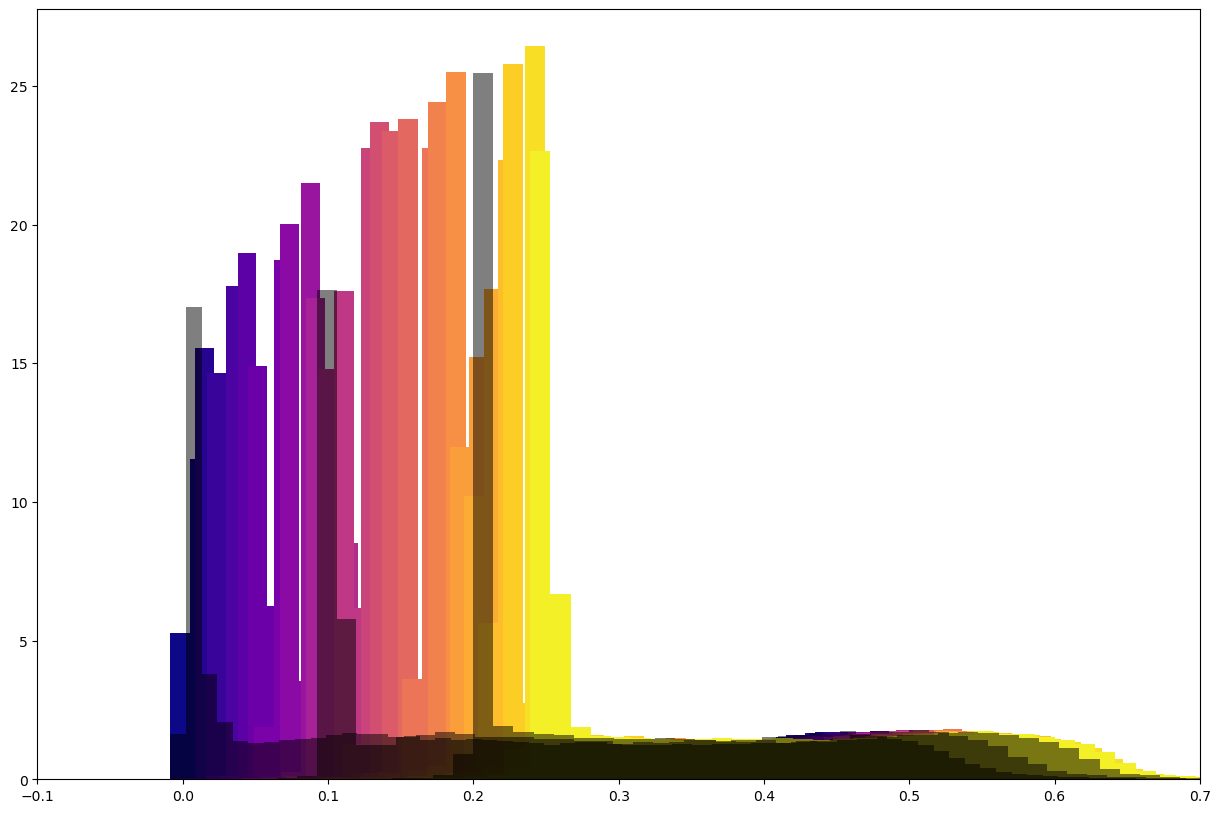

In [38]:
plt.rcParams["figure.figsize"] = (15,10)

for cb, chi_b in enumerate(np.linspace(0.,0.25,25)):
    hist, bin_edges = np.histogram(flow_samples_stack[cb*2,:,2], bins=100, density=True)
    #plt.step(np.linspace(bin_edges[0],bin_edges[-1],100), hist,color=colors[cb])
    plt.hist(flow_samples_stack[cb*2,:,2], bins=100, density=True, color=colors[cb*2])
    plt.xlim(-0.1,0.7)
plt.hist(flow_samples_chib0[:,2], bins=100, density=True, color='black', alpha=.5)
plt.hist(flow_samples_chib01[:,2], bins=100, density=True, color='black', alpha=.5)
plt.hist(flow_samples_chib02[:,2], bins=100, density=True, color='black', alpha=.5)


In [38]:
gaussian_samps = np.random.normal(loc=0., scale=1., size=(10000,4))
conds = np.repeat(np.array([[0.1]]),10000, axis=0)

mapped_samps = weighted_flow.flow.network.inverse(torch.from_numpy(gaussian_samps.astype(np.float32)), conditional=torch.from_numpy(conds.astype(np.float32)))

mapped_samps = mapped_samps[0].detach().numpy()
mapped_samps[:,0] = weighted_flow.expistic(mapped_samps[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
mapped_samps[:,1] = weighted_flow.expistic(mapped_samps[:,1], weighted_flow.mappings[2])
mapped_samps[:,2] = np.tanh(mapped_samps[:,2])
mapped_samps[:,3] = weighted_flow.expistic(mapped_samps[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

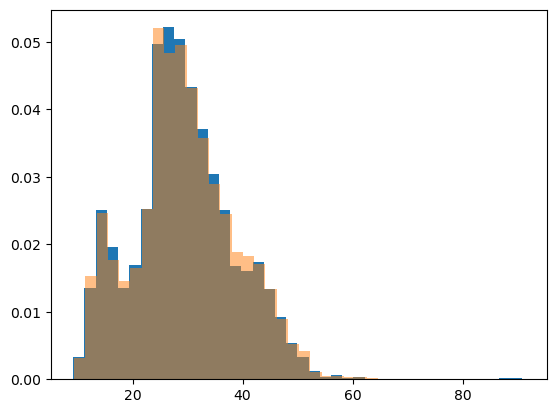

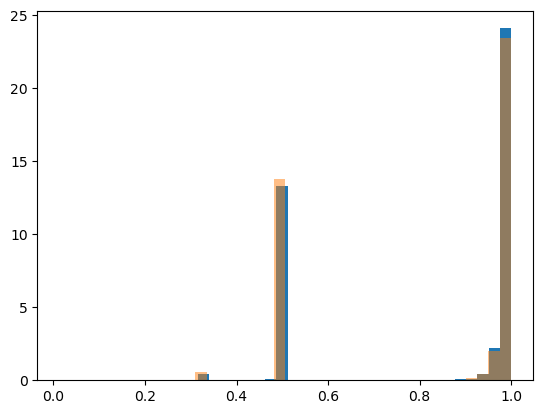

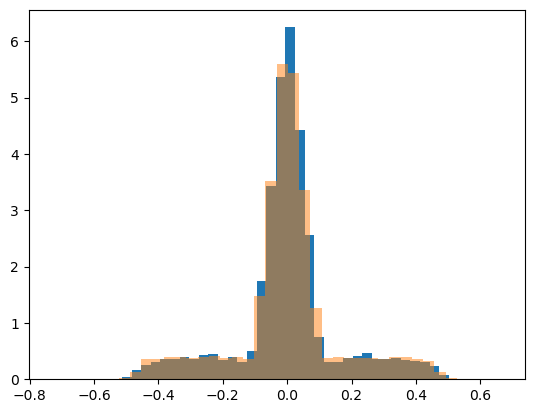

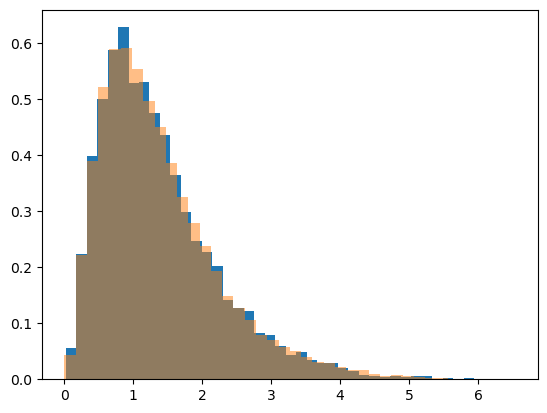

In [39]:
for i in range(no_params):
    fig, ax = plt.subplots((1))
    ax.hist(mapped_samps[:,i], bins=40, density=True)
    ax.hist(models_dict[1][:][param[i]], bins=40, density=True, weights=weights_dict[1], alpha=0.5)
